<a href="https://colab.research.google.com/github/Cristiaan0710/Proyecto-teorico-computacional/blob/main/Proyecto_optimizacion1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pip install aotools

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.2/46.2 kB 1.1 MB/s eta 0:00:00


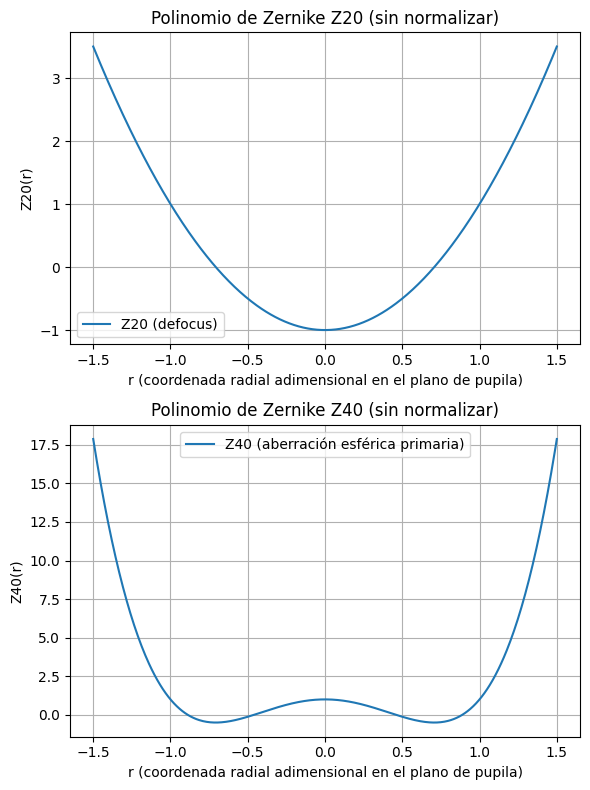

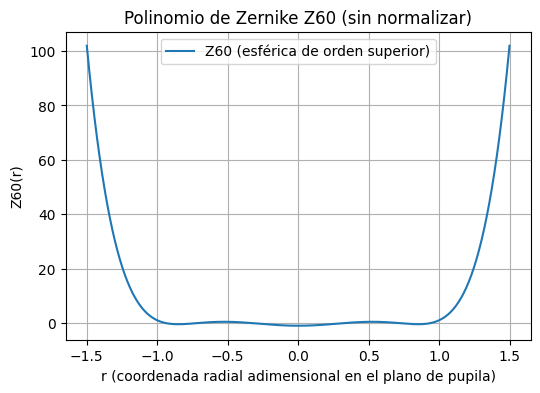

Optimization terminated successfully.
         Current function value: 0.008979
         Iterations: 32
         Function evaluations: 62

Coeficientes óptimos (uniforme): a4_uni=1.0585, a6_uni=0.0002

Umbral relativo para el área: 0.050 (≈ 5.0% del pico de difracción)

ÁREAS (intensidad relativa) entre cruces con el umbral:
  Sin SLM (sin esférica):        A = 1.772e-01
  Esférica base (no uniforme):   A = 1.733e-01
  Esférica uniforme (SLM):       A = 1.728e-01


/tmp/ipython-input-2695871995.py:178: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(I_rel[i0:i1+1], z[i0:i1+1])


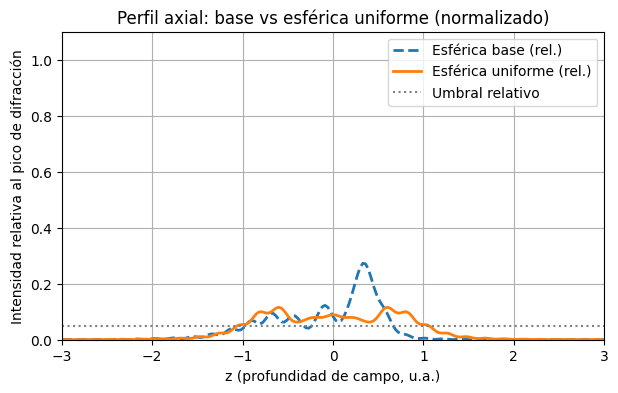

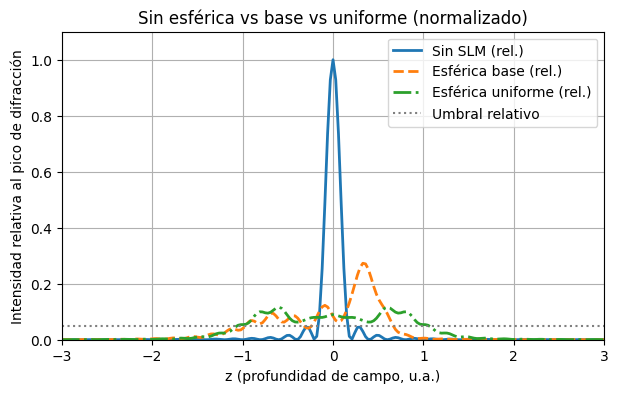

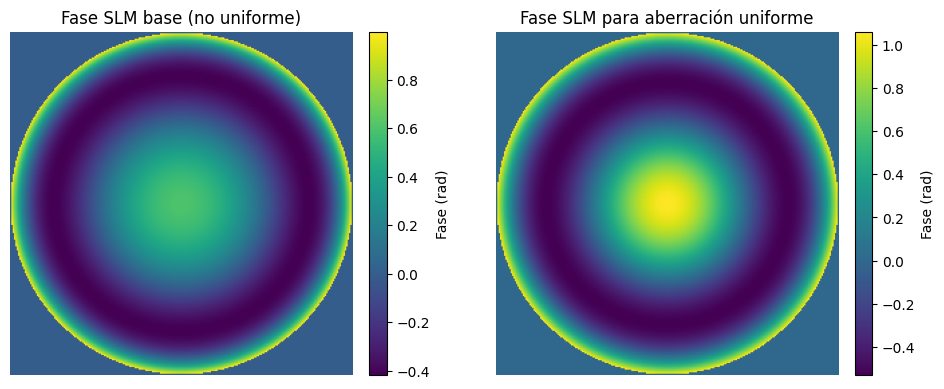

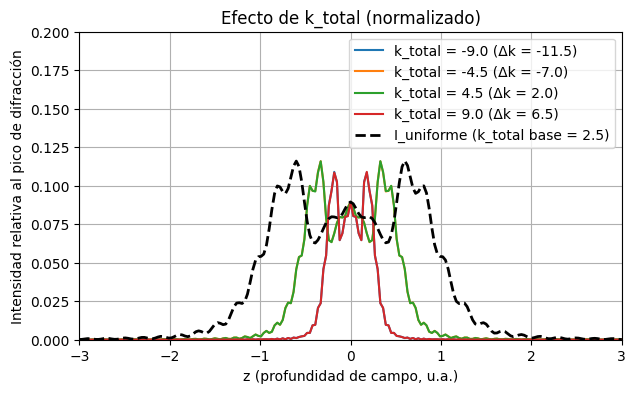

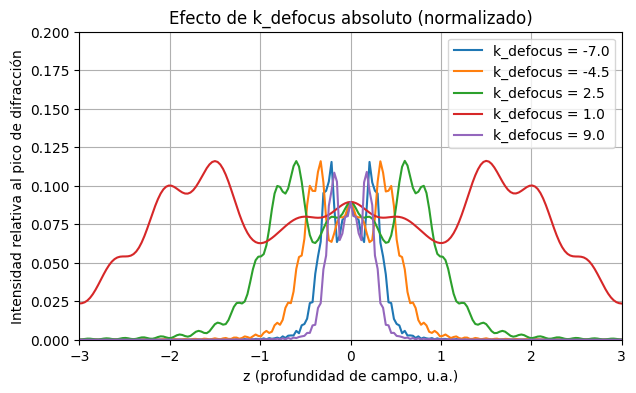

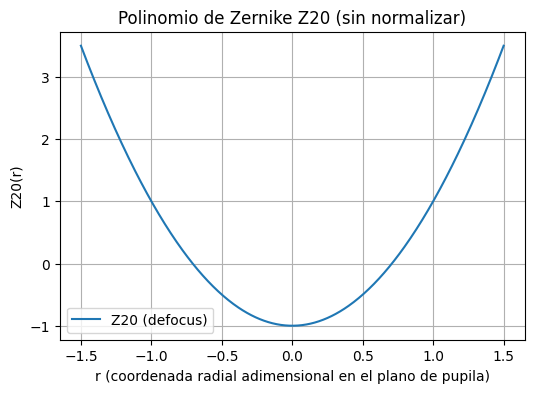

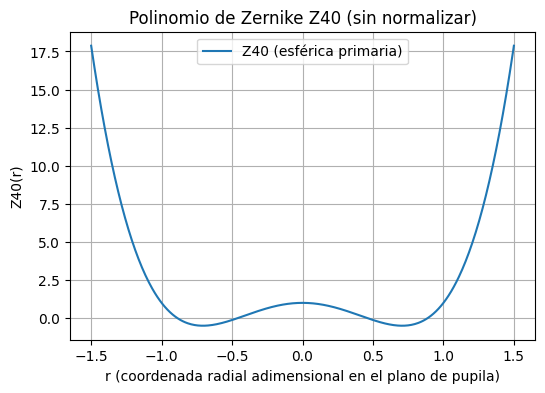

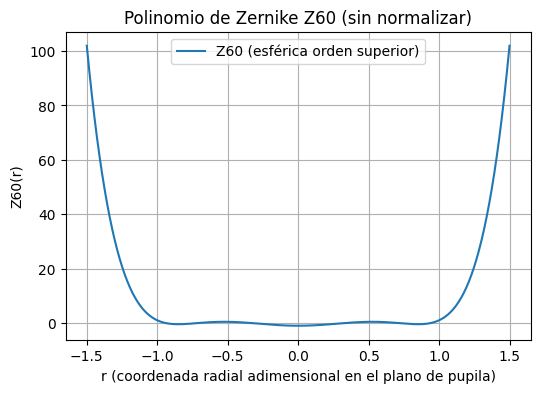

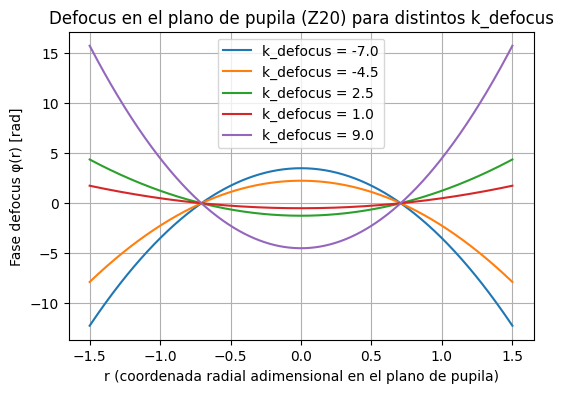

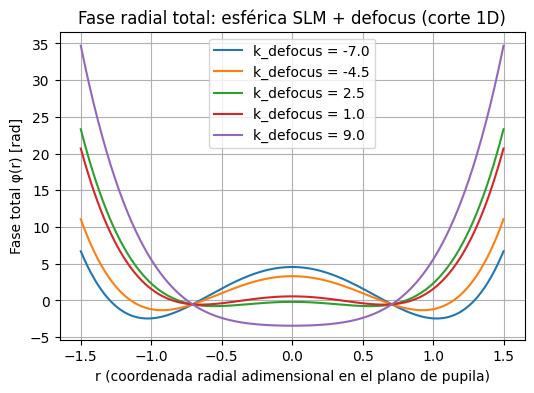

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# ============================================
# 0. POLINOMIOS DE ZERNIKE (DEFOCUS Y ESFÉRICA)
# ============================================

def Z20(r):  # Defocus (n=2, m=0)
    return 2*r**2 - 1

def Z40(r):  # Esférica primaria (n=4, m=0)
    return 6*r**4 - 6*r**2 + 1

def Z60(r):  # Esférica orden superior (n=6, m=0)
    return 20*r**6 - 30*r**4 + 12*r**2 - 1

# ---- Plots 1D de Z20, Z40 y Z60 (eje radial r) ----
r = np.linspace(-1.5, 1.5, 500)  # coordenada radial adimensional en la pupila

fig, axs = plt.subplots(2, 1, figsize=(6, 8))
axs[0].plot(r, Z20(r), label='Z20 (defocus)')
axs[0].set_xlabel('r (coordenada radial adimensional en el plano de pupila)')
axs[0].set_ylabel('Z20(r)')
axs[0].set_title('Polinomio de Zernike Z20 (sin normalizar)')
axs[0].grid(True); axs[0].legend()

axs[1].plot(r, Z40(r), label='Z40 (aberración esférica primaria)')
axs[1].set_xlabel('r (coordenada radial adimensional en el plano de pupila)')
axs[1].set_ylabel('Z40(r)')
axs[1].set_title('Polinomio de Zernike Z40 (sin normalizar)')
axs[1].grid(True); axs[1].legend()

plt.tight_layout(); plt.show()

plt.figure(figsize=(6,4))
plt.plot(r, Z60(r), label='Z60 (esférica de orden superior)')
plt.xlabel('r (coordenada radial adimensional en el plano de pupila)')
plt.ylabel('Z60(r)')
plt.title('Polinomio de Zernike Z60 (sin normalizar)')
plt.grid(True); plt.legend(); plt.show()


# ============================================
# 1. PARÁMETROS GENERALES DEL MODELO
# ============================================

# Tamaños para OPTIMIZAR (ligero)
N_opt  = 96
z_opt  = np.linspace(-3.0, 3.0, 41)  # eje z (profundidad)

# Tamaños para GRAFICAR (detallado)
N_full = 256
z_full = np.linspace(-3.0, 3.0, 201)

R_pupila  = 1.0
k_defocus = 2.5   # fuerza del defocus axial (valor base del sistema)

# "Base" (no uniforme) para punto de partida de la optimización
a4_base = 0.8
a6_base = 0.2


# ============================================
# 2. PUPILA (PLANO FOURIER) Y UTILIDADES
# ============================================

def prepara_pupila(N):
    x = np.linspace(-R_pupila, R_pupila, N)
    y = np.linspace(-R_pupila, R_pupila, N)
    X, Y = np.meshgrid(x, y)
    R = np.sqrt(X**2 + Y**2)
    apertura = (R <= 1.0).astype(float)
    return R, apertura

R_opt,  apertura_opt  = prepara_pupila(N_opt)
R_full, apertura_full = prepara_pupila(N_full)


# ============================================
# 3. PERFIL AXIAL I(z) PARA COEFICIENTES ESFÉRICOS (a4, a6)
# ============================================

def perfil_axial(R, apertura, z_array, a4_slm, a6_slm):
    """
    Intensidad en el centro de la PSF para todos los z, con:
       phi_slm = a4_slm·Z40(R) + a6_slm·Z60(R)
       phi_z   = k_defocus * z * Z20(R)
    Devuelve intensidades SIN normalizar.
    """
    phi_slm = a4_slm * Z40(R) + a6_slm * Z60(R)
    I_z = []
    for z in z_array:
        phi_z = k_defocus * z * Z20(R)
        pupila = apertura * np.exp(1j * 2*np.pi * (phi_slm + phi_z))
        campo = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(pupila)))
        inten = np.abs(campo)**2
        cy, cx = inten.shape[0]//2, inten.shape[1]//2
        I_z.append(inten[cy, cx])
    return np.array(I_z)


# ============================================
# 4. FUNCIÓN DE COSTE (aplana I(z) en una ventana)
# ============================================

def coste_uniforme(params):
    a4_slm, a6_slm = params
    I = perfil_axial(R_opt, apertura_opt, z_opt, a4_slm, a6_slm)
    z_min, z_max = -0.5, 0.5
    idx = (z_opt >= z_min) & (z_opt <= z_max)
    I_roi = I[idx]
    I_mean = I_roi.mean() if I_roi.size else 0.0
    if I_mean == 0: return 1e6
    I_norm = I_roi / I_mean
    target = np.ones_like(I_norm)
    return np.mean((I_norm - target)**2)


# ============================================
# 5. CURVAS SIN NORMALIZAR (para luego normalizar)
# ============================================

I_before   = perfil_axial(R_full, apertura_full, z_full, a4_base, a6_base)

# Optimización para esférica uniforme
x0  = np.array([a4_base, a6_base])
res = minimize(coste_uniforme, x0, method='Nelder-Mead',
               options={'maxiter': 80, 'disp': True})
a4_uni, a6_uni = res.x
print("\nCoeficientes óptimos (uniforme): a4_uni=%.4f, a6_uni=%.4f" % (a4_uni, a6_uni))

I_uniforme = perfil_axial(R_full, apertura_full, z_full, a4_uni, a6_uni)

# Sistema sin SLM (usa k_defocus base actual)
I_sin_slm = perfil_axial(R_full, apertura_full, z_full, a4_slm=0.0, a6_slm=0.0)


# ============================================
# 6. NORMALIZACIÓN CONSISTENTE + LÍMITES COMUNES
# ============================================

# Referencia física: pico de difracción (sin SLM y con k_defocus=0)
k_defocus_guardado = k_defocus
k_defocus = 0.0
I_ref = perfil_axial(R_full, apertura_full, z_full, a4_slm=0.0, a6_slm=0.0)
k_defocus = k_defocus_guardado

I_ref_peak = I_ref.max()  # factor de normalización fijo para TODAS las curvas

def norm(I):
    return I / I_ref_peak  # Intensidad relativa al pico de difracción

# Normalizadas
I_sin_slm_n  = norm(I_sin_slm)
I_before_n   = norm(I_before)
I_uniforme_n = norm(I_uniforme)

# Umbral RELATIVO (p.ej. 5% del pico de difracción)
noise_floor_factor = 0.05
threshold_rel = noise_floor_factor

# Límites comunes
z_min_plot, z_max_plot = z_full.min(), z_full.max()
y_min_plot, y_max_plot = 0.0, 1.1  # sube a 1.2 si tus curvas sobrepasan


# ============================================
# 7. ÁREA BAJO LA CURVA (con umbral RELATIVO)
# ============================================

def area_con_umbral_rel(z, I_rel, thr_rel):
    mask = (I_rel >= thr_rel)
    if np.count_nonzero(mask) < 2:
        return 0.0
    idx = np.where(mask)[0]
    i0, i1 = idx[0], idx[-1]
    return np.trapz(I_rel[i0:i1+1], z[i0:i1+1])

print(f"\nUmbral relativo para el área: {threshold_rel:.3f} "
      f"(≈ {noise_floor_factor*100:.1f}% del pico de difracción)")

area_sin   = area_con_umbral_rel(z_full, I_sin_slm_n,  threshold_rel)
area_base  = area_con_umbral_rel(z_full, I_before_n,   threshold_rel)
area_unif  = area_con_umbral_rel(z_full, I_uniforme_n, threshold_rel)

print("\nÁREAS (intensidad relativa) entre cruces con el umbral:")
print(f"  Sin SLM (sin esférica):        A = {area_sin:.3e}")
print(f"  Esférica base (no uniforme):   A = {area_base:.3e}")
print(f"  Esférica uniforme (SLM):       A = {area_unif:.3e}")


# ============================================
# 8. GRÁFICAS COMPARATIVAS (normalizadas, mismos ejes)
# ============================================

# base vs uniforme
plt.figure(figsize=(7, 4))
plt.plot(z_full, I_before_n,   '--', lw=2, label='Esférica base (rel.)')
plt.plot(z_full, I_uniforme_n, '-',  lw=2, label='Esférica uniforme (rel.)')
plt.axhline(threshold_rel, color='gray', linestyle=':', label='Umbral relativo')
plt.xlabel('z (profundidad de campo, u.a.)')
plt.ylabel('Intensidad relativa al pico de difracción')
plt.title('Perfil axial: base vs esférica uniforme (normalizado)')
plt.grid(True); plt.legend()
plt.xlim(z_min_plot, z_max_plot); plt.ylim(y_min_plot, y_max_plot)
plt.show()

# Sin SLM vs base vs uniforme
plt.figure(figsize=(7, 4))
plt.plot(z_full, I_sin_slm_n,  '-',  lw=2, label='Sin SLM (rel.)')
plt.plot(z_full, I_before_n,   '--', lw=2, label='Esférica base (rel.)')
plt.plot(z_full, I_uniforme_n, '-.', lw=2, label='Esférica uniforme (rel.)')
plt.axhline(threshold_rel, color='gray', linestyle=':', label='Umbral relativo')
plt.xlabel('z (profundidad de campo, u.a.)')
plt.ylabel('Intensidad relativa al pico de difracción')
plt.title('Sin esférica vs base vs uniforme (normalizado)')
plt.grid(True); plt.legend()
plt.xlim(z_min_plot, z_max_plot); plt.ylim(y_min_plot, y_max_plot)
plt.show()


# ============================================
# 9. MÁSCARAS DE FASE DEL SLM (para inspección)
# ============================================

def fase_slm(R, a4_slm, a6_slm):
    return a4_slm * Z40(R) + a6_slm * Z60(R)

phi_before   = fase_slm(R_full, a4_base, a6_base)
phi_uniforme = fase_slm(R_full, a4_uni,  a6_uni)

fig, axs = plt.subplots(1, 2, figsize=(10,4))
im0 = axs[0].imshow(phi_before * apertura_full, origin='lower', cmap='viridis')
axs[0].set_title('Fase SLM base (no uniforme)'); axs[0].axis('off')
plt.colorbar(im0, ax=axs[0], fraction=0.046, pad=0.04, label='Fase (rad)')

im1 = axs[1].imshow(phi_uniforme * apertura_full, origin='lower', cmap='viridis')
axs[1].set_title('Fase SLM para aberración uniforme'); axs[1].axis('off')
plt.colorbar(im1, ax=axs[1], fraction=0.046, pad=0.04, label='Fase (rad)')
plt.tight_layout(); plt.show()


# ============================================
# 10. PRUEBAS DE DEFOCUS (Δk alrededor del caso base)
# ============================================

def perfil_axial_con_kextra(R, apertura, z_array, a4_slm, a6_slm, k_extra):
    I_z = []
    phi_slm = a4_slm * Z40(R) + a6_slm * Z60(R)
    for z in z_array:
        k_total = k_defocus + k_extra
        phi_z = k_total * z * Z20(R)
        pupila = apertura * np.exp(1j * 2*np.pi * (phi_slm + phi_z))
        campo = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(pupila)))
        inten = np.abs(campo)**2
        cy, cx = inten.shape[0]//2, inten.shape[1]//2
        I_z.append(inten[cy, cx])
    return np.array(I_z)

k_total_vals = [-9.0, -4.5, 0.0, 4.5, 9.0]
k_extra_vals = [k_tot - k_defocus for k_tot in k_total_vals]

plt.figure(figsize=(7, 4))
for k_tot, k_extra in zip(k_total_vals, k_extra_vals):
    if np.isclose(k_tot, 0.0):  # el caso 0 produce línea plana con este modelo
        continue
    I_k  = perfil_axial_con_kextra(R_full, apertura_full, z_full, a4_uni, a6_uni, k_extra)
    I_kn = norm(I_k)
    plt.plot(z_full, I_kn, label=f'k_total = {k_tot:.1f} (Δk = {k_extra:.1f})')

plt.plot(z_full, I_uniforme_n, 'k--', lw=2,
         label=f'I_uniforme (k_total base = {k_defocus:.1f})')

plt.xlabel('z (profundidad de campo, u.a.)')
plt.ylabel('Intensidad relativa al pico de difracción')
plt.title('Efecto de k_total (normalizado)')
plt.grid(True); plt.legend()
plt.xlim(z_min_plot, z_max_plot); plt.ylim(y_min_plot, 0.2)
plt.show()


# ============================================
# 11. PRUEBAS con k_defocus ABSOLUTO (sin Δk)
# ============================================

def perfil_axial_con_k_defocus(R, apertura, z_array, a4_slm, a6_slm, k_defocus_local):
    I_z = []
    phi_slm = a4_slm * Z40(R) + a6_slm * Z60(R)
    for z in z_array:
        phi_z = k_defocus_local * z * Z20(R)
        pupila = apertura * np.exp(1j * 2*np.pi * (phi_slm + phi_z))
        campo = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(pupila)))
        inten = np.abs(campo)**2
        cy, cx = inten.shape[0]//2, inten.shape[1]//2
        I_z.append(inten[cy, cx])
    return np.array(I_z)

k_defocus_vals = [-7.0, -4.5, 2.5, 1.0, 9.0]

plt.figure(figsize=(7, 4))
for k_loc in k_defocus_vals:
    I_k  = perfil_axial_con_k_defocus(R_full, apertura_full, z_full, a4_uni, a6_uni, k_loc)
    I_kn = norm(I_k)
    plt.plot(z_full, I_kn, label=f'k_defocus = {k_loc:.1f}')
plt.xlabel('z (profundidad de campo, u.a.)')
plt.ylabel('Intensidad relativa al pico de difracción')
plt.title('Efecto de k_defocus absoluto (normalizado)')
plt.grid(True); plt.legend()
plt.xlim(z_min_plot, z_max_plot); plt.ylim(y_min_plot, 0.2)
plt.show()


# ============================================
# 12. Cortes radiales (1D) en la pupila (ilustrativos)
# ============================================

r_1d = np.linspace(-1.5, 1.5, 500)
Z20_1d, Z40_1d, Z60_1d = Z20(r_1d), Z40(r_1d), Z60(r_1d)

plt.figure(figsize=(6, 4))
plt.plot(r_1d, Z20_1d, label='Z20 (defocus)')
plt.xlabel('r (coordenada radial adimensional en el plano de pupila)')
plt.ylabel('Z20(r)'); plt.title('Polinomio de Zernike Z20 (sin normalizar)')
plt.grid(True); plt.legend(); plt.show()

plt.figure(figsize=(6, 4))
plt.plot(r_1d, Z40_1d, label='Z40 (esférica primaria)')
plt.xlabel('r (coordenada radial adimensional en el plano de pupila)')
plt.ylabel('Z40(r)'); plt.title('Polinomio de Zernike Z40 (sin normalizar)')
plt.grid(True); plt.legend(); plt.show()

plt.figure(figsize=(6, 4))
plt.plot(r_1d, Z60_1d, label='Z60 (esférica orden superior)')
plt.xlabel('r (coordenada radial adimensional en el plano de pupila)')
plt.ylabel('Z60(r)'); plt.title('Polinomio de Zernike Z60 (sin normalizar)')
plt.grid(True); plt.legend(); plt.show()

# Solo defocus en la pupila para distintos k (fase vs r)
k_vals = [-7.0, -4.5, 2.5, 1.0, 9.0]
z0 = 0.5  # z fijo para visualizar fase
plt.figure(figsize=(6, 4))
for k in k_vals:
    phi_def = k * z0 * Z20_1d
    plt.plot(r_1d, phi_def, label=f'k_defocus = {k}')
plt.xlabel('r (coordenada radial adimensional en el plano de pupila)')
plt.ylabel('Fase defocus φ(r) [rad]')
plt.title('Defocus en el plano de pupila (Z20) para distintos k_defocus')
plt.grid(True); plt.legend(); plt.show()

# Fase TOTAL radial: esférica SLM + defocus
phi_slm_uni_1d = a4_uni * Z40_1d + a6_uni * Z60_1d
plt.figure(figsize=(6, 4))
for k in k_vals:
    phi_total = phi_slm_uni_1d + k * z0 * Z20_1d
    plt.plot(r_1d, phi_total, label=f'k_defocus = {k}')
plt.xlabel('r (coordenada radial adimensional en el plano de pupila)')
plt.ylabel('Fase total φ(r) [rad]')
plt.title('Fase radial total: esférica SLM + defocus (corte 1D)')
plt.grid(True); plt.legend(); plt.show()


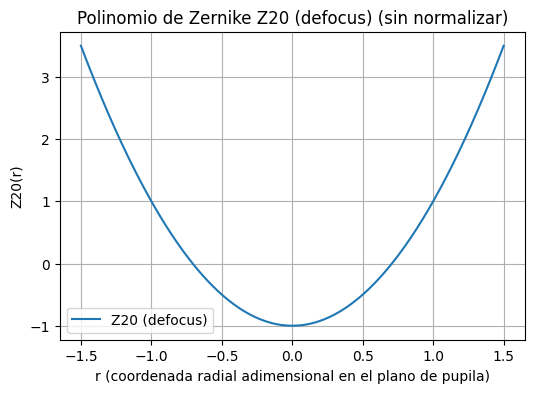

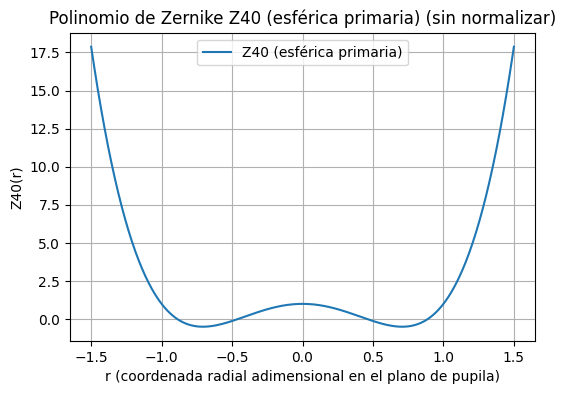

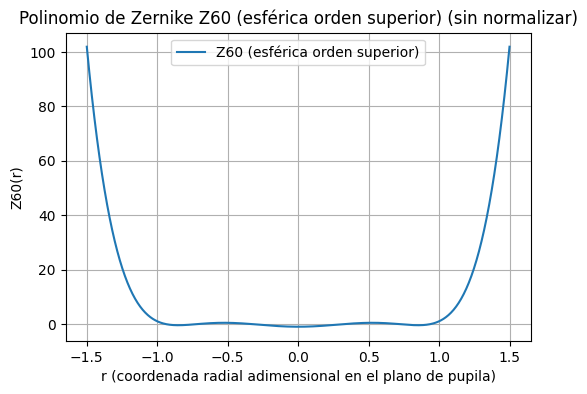

Optimization terminated successfully.
         Current function value: 0.008979
         Iterations: 32
         Function evaluations: 62

Coeficientes óptimos del SLM para aberración uniforme:
  a4_uni = 1.0585
  a6_uni = 0.0002

ÁREAS RELATIVAS (normalizadas al pico sin SLM, umbral relativo):
  Sin SLM (rel.):        A = 1.772e-01
  Esférica base (rel.):  A = 1.534e-01
  Esférica uniforme (rel.): A = 1.508e-01


/tmp/ipython-input-1602890361.py:147: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(I_rel[i0:i1+1], z[i0:i1+1])


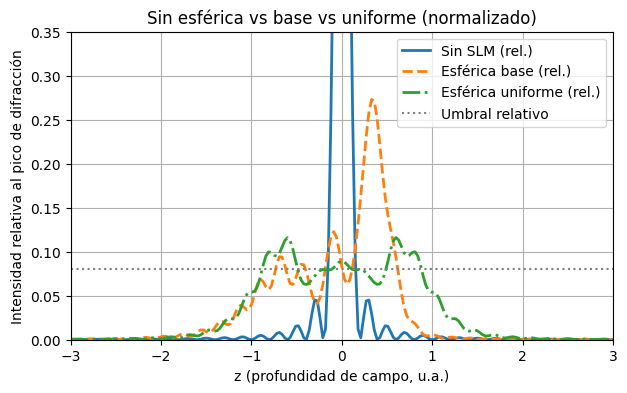

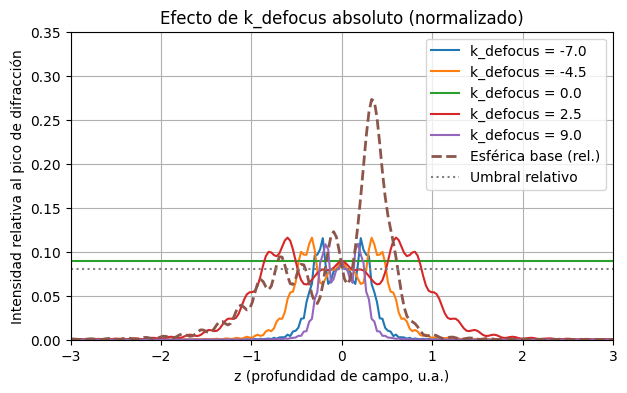

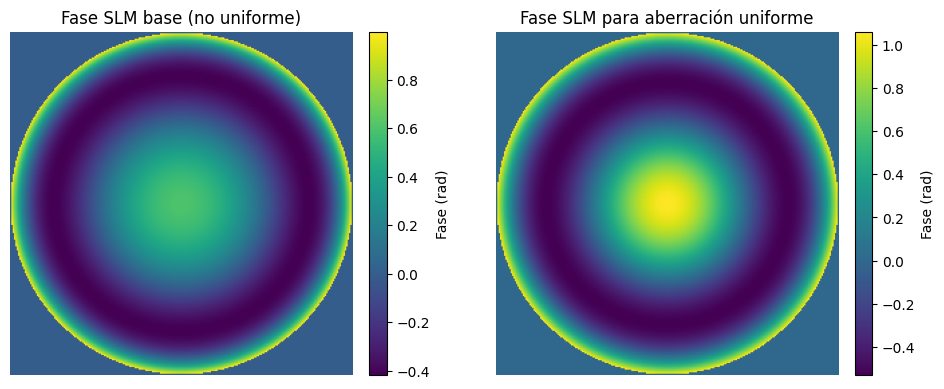

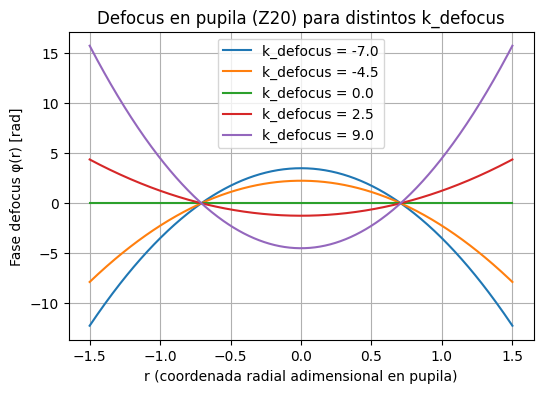

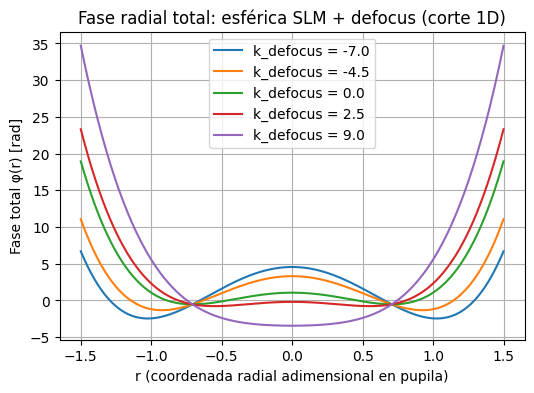

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# ============================================
# 0. POLINOMIOS DE ZERNIKE (DEFOCUS Y ESFÉRICA)
# ============================================

def Z20(r):
    """Defocus (n=2, m=0)"""
    return 2*r**2 - 1

def Z40(r):
    """Esférica primaria (n=4, m=0)"""
    return 6*r**4 - 6*r**2 + 1

def Z60(r):
    """Esférica orden superior (n=6, m=0)"""
    return 20*r**6 - 30*r**4 + 12*r**2 - 1

# (Opcional) Vista 1D rápida de Zernike
r = np.linspace(-1.5, 1.5, 500)
for Zf, name in [(Z20, "Z20 (defocus)"),
                 (Z40, "Z40 (esférica primaria)"),
                 (Z60, "Z60 (esférica orden superior)")]:
    plt.figure(figsize=(6,4))
    plt.plot(r, Zf(r), label=name)
    plt.xlabel('r (coordenada radial adimensional en el plano de pupila)')
    plt.ylabel(f'{name.split()[0]}(r)')
    plt.title(f'Polinomio de Zernike {name} (sin normalizar)')
    plt.grid(True); plt.legend(); plt.show()

# ============================================
# 1. PARÁMETROS GENERALES DEL MODELO
# ============================================

# Tamaños para OPTIMIZAR (ligero)
N_opt  = 96
z_opt  = np.linspace(-3.0, 3.0, 41)      # eje z (profundidad)

# Tamaños para GRAFICAR (detallado)
N_full = 256
z_full = np.linspace(-3.0, 3.0, 201)     # más puntos para curvas suaves

R_pupila = 1.0
k_defocus = 2.5                          # fuerza del defocus "base" del sistema

# Coeficientes de esférica "base" (punto de partida de la optimización)
a4_base = 0.8    # coeficiente de Z40
a6_base = 0.2    # coeficiente de Z60

# ============================================
# 2. PUPILA (PLANO FOURIER) Y UTILIDADES
# ============================================

def prepara_pupila(N):
    x = np.linspace(-R_pupila, R_pupila, N)
    y = np.linspace(-R_pupila, R_pupila, N)
    X, Y = np.meshgrid(x, y)
    R = np.sqrt(X**2 + Y**2)
    apertura = (R <= 1.0).astype(float)
    return R, apertura

R_opt,  apertura_opt  = prepara_pupila(N_opt)
R_full, apertura_full = prepara_pupila(N_full)

# ============================================
# 3. PERFIL AXIAL I(z) PARA (a4, a6)
# ============================================

def perfil_axial(R, apertura, z_array, a4_slm, a6_slm, k_def=k_defocus):
    """
    Calcula I(z) en el centro de la PSF con fase:
       phi_total = a4*Z40(R) + a6*Z60(R) + k_def * z * Z20(R)
    """
    phi_slm = a4_slm * Z40(R) + a6_slm * Z60(R)
    I_z = []
    for z in z_array:
        phi_z = k_def * z * Z20(R)
        fase_total = phi_slm + phi_z
        pupila = apertura * np.exp(1j * 2*np.pi * fase_total)
        campo = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(pupila)))
        intensidad = np.abs(campo)**2
        cy, cx = intensidad.shape[0]//2, intensidad.shape[1]//2
        I_z.append(intensidad[cy, cx])
    return np.array(I_z)

# ============================================
# 4. FUNCIÓN DE COSTE: ABERRACIÓN "UNIFORME" EN z
# ============================================

def coste_uniforme(params):
    a4_slm, a6_slm = params
    I = perfil_axial(R_opt, apertura_opt, z_opt, a4_slm, a6_slm, k_def=k_defocus)
    z_min, z_max = -0.5, 0.5
    idx = (z_opt >= z_min) & (z_opt <= z_max)
    I_roi = I[idx]
    I_mean = I_roi.mean()
    if I_mean == 0:
        return 1e6
    I_norm = I_roi / I_mean
    return np.mean((I_norm - 1.0)**2)

# ============================================
# 5. CURVAS "BASE" Y OPTIMIZACIÓN PARA ESFÉRICA UNIFORME
# ============================================

# Esférica base (no uniforme)
I_before = perfil_axial(R_full, apertura_full, z_full, a4_base, a6_base, k_def=k_defocus)

# Optimización
x0 = np.array([a4_base, a6_base])
res = minimize(coste_uniforme, x0, method='Nelder-Mead',
               options={'maxiter': 80, 'disp': True})
a4_uni, a6_uni = res.x
print("\nCoeficientes óptimos del SLM para aberración uniforme:")
print(f"  a4_uni = {a4_uni:.4f}")
print(f"  a6_uni = {a6_uni:.4f}")

# Esférica uniforme (SLM optimizado)
I_uniforme = perfil_axial(R_full, apertura_full, z_full, a4_uni, a6_uni, k_def=k_defocus)

# Sistema sin SLM (referencia del pico de difracción)
I_sin_slm = perfil_axial(R_full, apertura_full, z_full, a4_slm=0.0, a6_slm=0.0, k_def=k_defocus)

# ============================================
# 6. NORMALIZACIÓN COMÚN Y UMBRAL RELATIVO
# ============================================

# Normalización respecto al pico de difracción sin SLM
I_diff_peak  = I_sin_slm.max()
I_before_rel   = I_before   / I_diff_peak
I_uniforme_rel = I_uniforme / I_diff_peak
I_sin_rel      = I_sin_slm  / I_diff_peak

# Umbral relativo (para áreas y líneas guía)
thr_rel = 0.08
y_rel_min, y_rel_max = 0.0, 0.35   # << sube/baja este valor si quieres más aire vertical

def area_con_umbral_rel(z, I_rel, thr):
    """Área relativa entre primeros/últimos cruces con el umbral relativo."""
    mask = (I_rel >= thr)
    if np.count_nonzero(mask) < 2:
        return 0.0
    idx = np.where(mask)[0]
    i0, i1 = idx[0], idx[-1]
    return np.trapz(I_rel[i0:i1+1], z[i0:i1+1])

area_sin_rel  = area_con_umbral_rel(z_full, I_sin_rel,      thr_rel)
area_base_rel = area_con_umbral_rel(z_full, I_before_rel,   thr_rel)
area_unif_rel = area_con_umbral_rel(z_full, I_uniforme_rel, thr_rel)

print("\nÁREAS RELATIVAS (normalizadas al pico sin SLM, umbral relativo):")
print(f"  Sin SLM (rel.):        A = {area_sin_rel:.3e}")
print(f"  Esférica base (rel.):  A = {area_base_rel:.3e}")
print(f"  Esférica uniforme (rel.): A = {area_unif_rel:.3e}")

# ============================================
# 7. COMPARATIVA: Sin, Base, Uniforme (normalizado, mismos ejes)
# ============================================

plt.figure(figsize=(7, 4))
plt.plot(z_full, I_sin_rel,      '-',  lw=2, label='Sin SLM (rel.)')
plt.plot(z_full, I_before_rel,   '--', lw=2, label='Esférica base (rel.)')
plt.plot(z_full, I_uniforme_rel, '-.', lw=2, label='Esférica uniforme (rel.)')
plt.axhline(thr_rel, color='gray', linestyle=':', label='Umbral relativo')
plt.xlabel('z (profundidad de campo, u.a.)')
plt.ylabel('Intensidad relativa al pico de difracción')
plt.title('Sin esférica vs base vs uniforme (normalizado)')
plt.grid(True); plt.legend()
plt.xlim(-3.0, 3.0); plt.ylim(y_rel_min, y_rel_max)
plt.show()

# ============================================
# 8. PRUEBAS: k_defocus ABSOLUTO (todas normalizadas)
#    + referencia de esférica base en la misma figura
# ============================================

def perfil_axial_con_k_defocus(R, apertura, z_array, a4_slm, a6_slm, k_defocus_local):
    """Igual que perfil_axial, pero forzando k_defocus_local."""
    return perfil_axial(R, apertura, z_array, a4_slm, a6_slm, k_def=k_defocus_local)

k_defocus_vals = [-7.0, -4.5, 0.0, 2.5, 9.0]

plt.figure(figsize=(7, 4))
for k_loc in k_defocus_vals:
    I_k = perfil_axial_con_k_defocus(R_full, apertura_full, z_full,
                                     a4_slm=a4_uni, a6_slm=a6_uni,
                                     k_defocus_local=k_loc)
    I_k_rel = I_k / I_diff_peak
    plt.plot(z_full, I_k_rel, label=f'k_defocus = {k_loc:.1f}')

# <<< NUEVO: curva de esférica base en la misma gráfica >>>
plt.plot(z_full, I_before_rel, '--', lw=2, label='Esférica base (rel.)')

plt.axhline(thr_rel, color='gray', linestyle=':', label='Umbral relativo')
plt.xlabel('z (profundidad de campo, u.a.)')
plt.ylabel('Intensidad relativa al pico de difracción')
plt.title('Efecto de k_defocus absoluto (normalizado)')
plt.grid(True); plt.legend()
plt.ylim(y_rel_min, y_rel_max); plt.xlim(-3.0, 3.0)
plt.show()

# ============================================
# 9. MÁSCARAS DE FASE DEL SLM (visualización)
# ============================================

def fase_slm(R, a4_slm, a6_slm):
    return a4_slm * Z40(R) + a6_slm * Z60(R)

phi_before   = fase_slm(R_full, a4_base, a6_base)
phi_uniforme = fase_slm(R_full, a4_uni,  a6_uni)

fig, axs = plt.subplots(1, 2, figsize=(10,4))
im0 = axs[0].imshow(phi_before * apertura_full, origin='lower', cmap='viridis')
axs[0].set_title('Fase SLM base (no uniforme)'); axs[0].axis('off')
plt.colorbar(im0, ax=axs[0], fraction=0.046, pad=0.04, label='Fase (rad)')

im1 = axs[1].imshow(phi_uniforme * apertura_full, origin='lower', cmap='viridis')
axs[1].set_title('Fase SLM para aberración uniforme'); axs[1].axis('off')
plt.colorbar(im1, ax=axs[1], fraction=0.046, pad=0.04, label='Fase (rad)')
plt.tight_layout(); plt.show()

# ============================================
# 10. Cortes radiales (1D) en pupila: Zernike y k_defocus
# ============================================

r_1d = np.linspace(-1.5, 1.5, 500)
Z20_1d, Z40_1d, Z60_1d = Z20(r_1d), Z40(r_1d), Z60(r_1d)

# Solo defocus en la pupila para distintos k (fase vs r)
k_vals = [-7.0, -4.5, 0.0, 2.5, 9.0]
z0 = 0.5  # profundidad fija para visualizar fase radial

plt.figure(figsize=(6, 4))
for k in k_vals:
    phi_def = k * z0 * Z20_1d
    plt.plot(r_1d, phi_def, label=f'k_defocus = {k}')
plt.xlabel('r (coordenada radial adimensional en pupila)')
plt.ylabel('Fase defocus φ(r) [rad]')
plt.title('Defocus en pupila (Z20) para distintos k_defocus')
plt.grid(True); plt.legend(); plt.show()

# Fase TOTAL radial: esférica uniforme del SLM + defocus
phi_slm_uni_1d = a4_uni * Z40_1d + a6_uni * Z60_1d
plt.figure(figsize=(6, 4))
for k in k_vals:
    phi_total = phi_slm_uni_1d + k * z0 * Z20_1d
    plt.plot(r_1d, phi_total, label=f'k_defocus = {k}')
plt.xlabel('r (coordenada radial adimensional en pupila)')
plt.ylabel('Fase total φ(r) [rad]')
plt.title('Fase radial total: esférica SLM + defocus (corte 1D)')
plt.grid(True); plt.legend(); plt.show()


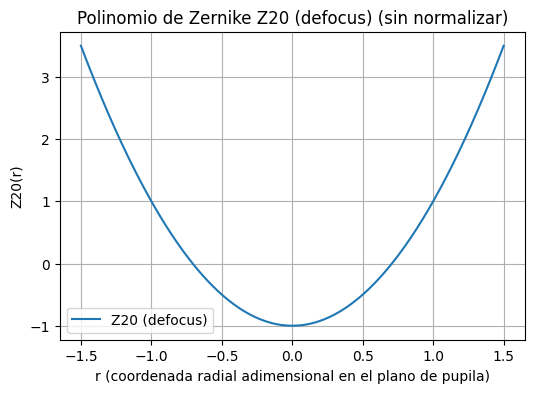

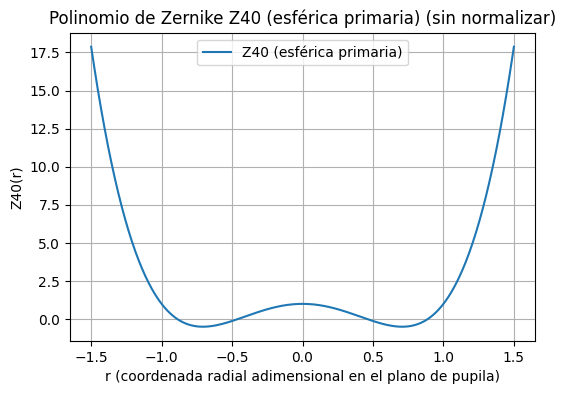

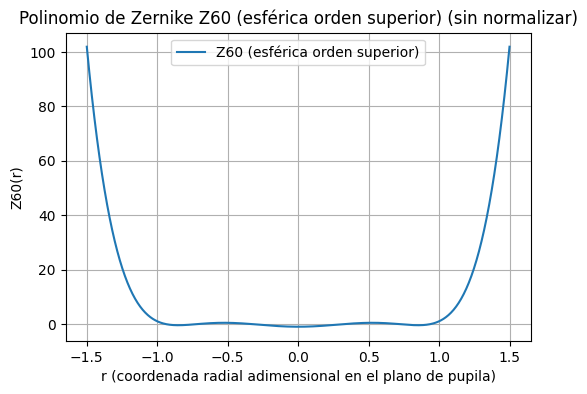

Optimization terminated successfully.
         Current function value: 0.019657
         Iterations: 21
         Function evaluations: 40

Coeficientes óptimos del SLM para aberración uniforme:
  a4_uni = 0.7071
  a6_uni = -0.0000

ÁREAS RELATIVAS (normalizadas al pico sin SLM, umbral relativo):
  Sin SLM (rel.):        A = 1.772e-01
  Esférica base (rel.):  A = 1.581e-01
  Esférica uniforme (rel.): A = 1.653e-01


/tmp/ipython-input-2393849526.py:147: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(I_rel[i0:i1+1], z[i0:i1+1])


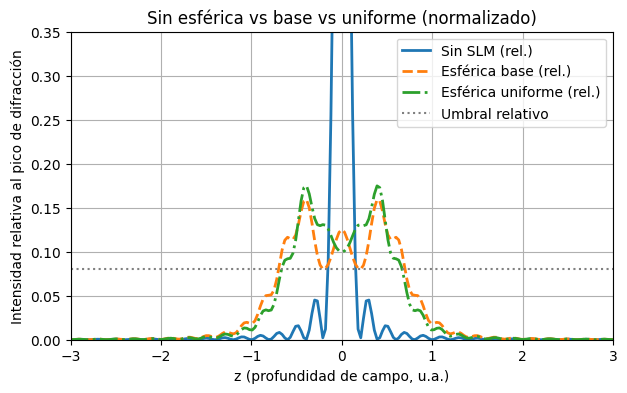

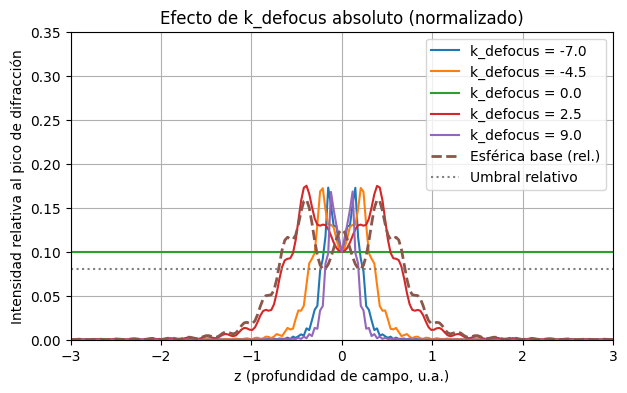

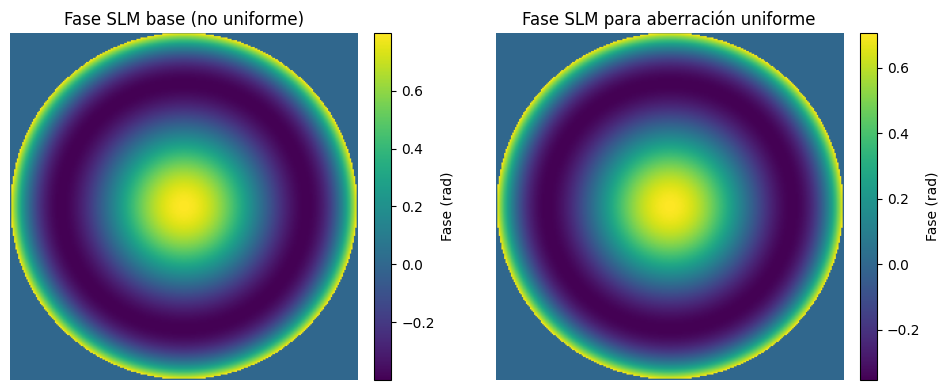

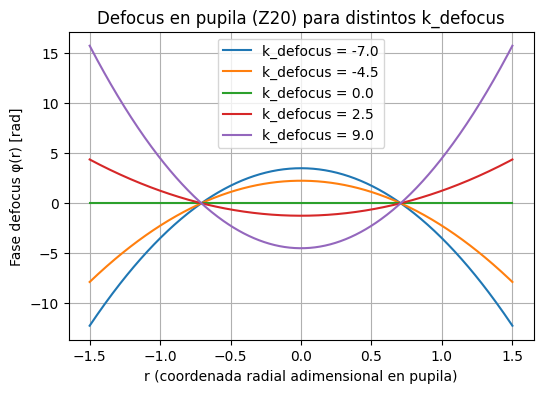

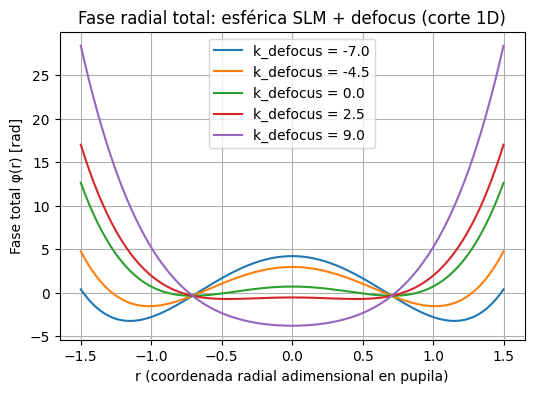

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# ============================================
# 0. POLINOMIOS DE ZERNIKE (DEFOCUS Y ESFÉRICA)
# ============================================

def Z20(r):
    """Defocus (n=2, m=0)"""
    return 2*r**2 - 1

def Z40(r):
    """Esférica primaria (n=4, m=0)"""
    return 6*r**4 - 6*r**2 + 1

def Z60(r):
    """Esférica orden superior (n=6, m=0)"""
    return 20*r**6 - 30*r**4 + 12*r**2 - 1

# (Opcional) Vista 1D rápida de Zernike
r = np.linspace(-1.5, 1.5, 500)
for Zf, name in [(Z20, "Z20 (defocus)"),
                 (Z40, "Z40 (esférica primaria)"),
                 (Z60, "Z60 (esférica orden superior)")]:
    plt.figure(figsize=(6,4))
    plt.plot(r, Zf(r), label=name)
    plt.xlabel('r (coordenada radial adimensional en el plano de pupila)')
    plt.ylabel(f'{name.split()[0]}(r)')
    plt.title(f'Polinomio de Zernike {name} (sin normalizar)')
    plt.grid(True); plt.legend(); plt.show()

# ============================================
# 1. PARÁMETROS GENERALES DEL MODELO
# ============================================

# Tamaños para OPTIMIZAR (ligero)
N_opt  = 96
z_opt  = np.linspace(-3.0, 3.0, 41)      # eje z (profundidad)

# Tamaños para GRAFICAR (detallado)
N_full = 256
z_full = np.linspace(-3.0, 3.0, 201)     # más puntos para curvas suaves

R_pupila = 1.0
k_defocus = 2.5                          # fuerza del defocus "base" del sistema

# Coeficientes de esférica "base" (punto de partida de la optimización)
a4_base = 0.8    # coeficiente de Z40
a6_base = 0.0    # coeficiente de Z60

# ============================================
# 2. PUPILA (PLANO FOURIER) Y UTILIDADES
# ============================================

def prepara_pupila(N):
    x = np.linspace(-R_pupila, R_pupila, N)
    y = np.linspace(-R_pupila, R_pupila, N)
    X, Y = np.meshgrid(x, y)
    R = np.sqrt(X**2 + Y**2)
    apertura = (R <= 1.0).astype(float)
    return R, apertura

R_opt,  apertura_opt  = prepara_pupila(N_opt)
R_full, apertura_full = prepara_pupila(N_full)

# ============================================
# 3. PERFIL AXIAL I(z) PARA (a4, a6)
# ============================================

def perfil_axial(R, apertura, z_array, a4_slm, a6_slm, k_def=k_defocus):
    """
    Calcula I(z) en el centro de la PSF con fase:
       phi_total = a4*Z40(R) + a6*Z60(R) + k_def * z * Z20(R)
    """
    phi_slm = a4_slm * Z40(R) + a6_slm * Z60(R)
    I_z = []
    for z in z_array:
        phi_z = k_def * z * Z20(R)
        fase_total = phi_slm + phi_z
        pupila = apertura * np.exp(1j * 2*np.pi * fase_total)
        campo = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(pupila)))
        intensidad = np.abs(campo)**2
        cy, cx = intensidad.shape[0]//2, intensidad.shape[1]//2
        I_z.append(intensidad[cy, cx])
    return np.array(I_z)

# ============================================
# 4. FUNCIÓN DE COSTE: ABERRACIÓN "UNIFORME" EN z
# ============================================

def coste_uniforme(params):
    a4_slm, a6_slm = params
    I = perfil_axial(R_opt, apertura_opt, z_opt, a4_slm, a6_slm, k_def=k_defocus)
    z_min, z_max = -0.5, 0.5
    idx = (z_opt >= z_min) & (z_opt <= z_max)
    I_roi = I[idx]
    I_mean = I_roi.mean()
    if I_mean == 0:
        return 1e6
    I_norm = I_roi / I_mean
    return np.mean((I_norm - 1.0)**2)

# ============================================
# 5. CURVAS "BASE" Y OPTIMIZACIÓN PARA ESFÉRICA UNIFORME
# ============================================

# Esférica base (no uniforme)
I_before = perfil_axial(R_full, apertura_full, z_full, a4_base, a6_base, k_def=k_defocus)

# Optimización
x0 = np.array([a4_base, a6_base])
res = minimize(coste_uniforme, x0, method='Nelder-Mead',
               options={'maxiter': 80, 'disp': True})
a4_uni, a6_uni = res.x
print("\nCoeficientes óptimos del SLM para aberración uniforme:")
print(f"  a4_uni = {a4_uni:.4f}")
print(f"  a6_uni = {a6_uni:.4f}")

# Esférica uniforme (SLM optimizado)
I_uniforme = perfil_axial(R_full, apertura_full, z_full, a4_uni, a6_uni, k_def=k_defocus)

# Sistema sin SLM (referencia del pico de difracción)
I_sin_slm = perfil_axial(R_full, apertura_full, z_full, a4_slm=0.0, a6_slm=0.0, k_def=k_defocus)

# ============================================
# 6. NORMALIZACIÓN COMÚN Y UMBRAL RELATIVO
# ============================================

# Normalización respecto al pico de difracción sin SLM
I_diff_peak  = I_sin_slm.max()
I_before_rel   = I_before   / I_diff_peak
I_uniforme_rel = I_uniforme / I_diff_peak
I_sin_rel      = I_sin_slm  / I_diff_peak

# Umbral relativo (para áreas y líneas guía)
thr_rel = 0.08
y_rel_min, y_rel_max = 0.0, 0.35   # << sube/baja este valor si quieres más aire vertical

def area_con_umbral_rel(z, I_rel, thr):
    """Área relativa entre primeros/últimos cruces con el umbral relativo."""
    mask = (I_rel >= thr)
    if np.count_nonzero(mask) < 2:
        return 0.0
    idx = np.where(mask)[0]
    i0, i1 = idx[0], idx[-1]
    return np.trapz(I_rel[i0:i1+1], z[i0:i1+1])

area_sin_rel  = area_con_umbral_rel(z_full, I_sin_rel,      thr_rel)
area_base_rel = area_con_umbral_rel(z_full, I_before_rel,   thr_rel)
area_unif_rel = area_con_umbral_rel(z_full, I_uniforme_rel, thr_rel)

print("\nÁREAS RELATIVAS (normalizadas al pico sin SLM, umbral relativo):")
print(f"  Sin SLM (rel.):        A = {area_sin_rel:.3e}")
print(f"  Esférica base (rel.):  A = {area_base_rel:.3e}")
print(f"  Esférica uniforme (rel.): A = {area_unif_rel:.3e}")

# ============================================
# 7. COMPARATIVA: Sin, Base, Uniforme (normalizado, mismos ejes)
# ============================================

plt.figure(figsize=(7, 4))
plt.plot(z_full, I_sin_rel,      '-',  lw=2, label='Sin SLM (rel.)')
plt.plot(z_full, I_before_rel,   '--', lw=2, label='Esférica base (rel.)')
plt.plot(z_full, I_uniforme_rel, '-.', lw=2, label='Esférica uniforme (rel.)')
plt.axhline(thr_rel, color='gray', linestyle=':', label='Umbral relativo')
plt.xlabel('z (profundidad de campo, u.a.)')
plt.ylabel('Intensidad relativa al pico de difracción')
plt.title('Sin esférica vs base vs uniforme (normalizado)')
plt.grid(True); plt.legend()
plt.xlim(-3.0, 3.0); plt.ylim(y_rel_min, y_rel_max)
plt.show()

# ============================================
# 8. PRUEBAS: k_defocus ABSOLUTO (todas normalizadas)
#    + referencia de esférica base en la misma figura
# ============================================

def perfil_axial_con_k_defocus(R, apertura, z_array, a4_slm, a6_slm, k_defocus_local):
    """Igual que perfil_axial, pero forzando k_defocus_local."""
    return perfil_axial(R, apertura, z_array, a4_slm, a6_slm, k_def=k_defocus_local)

k_defocus_vals = [-7.0, -4.5, 0.0, 2.5, 9.0]

plt.figure(figsize=(7, 4))
for k_loc in k_defocus_vals:
    I_k = perfil_axial_con_k_defocus(R_full, apertura_full, z_full,
                                     a4_slm=a4_uni, a6_slm=a6_uni,
                                     k_defocus_local=k_loc)
    I_k_rel = I_k / I_diff_peak
    plt.plot(z_full, I_k_rel, label=f'k_defocus = {k_loc:.1f}')

# <<< NUEVO: curva de esférica base en la misma gráfica >>>
plt.plot(z_full, I_before_rel, '--', lw=2, label='Esférica base (rel.)')

plt.axhline(thr_rel, color='gray', linestyle=':', label='Umbral relativo')
plt.xlabel('z (profundidad de campo, u.a.)')
plt.ylabel('Intensidad relativa al pico de difracción')
plt.title('Efecto de k_defocus absoluto (normalizado)')
plt.grid(True); plt.legend()
plt.ylim(y_rel_min, y_rel_max); plt.xlim(-3.0, 3.0)
plt.show()

# ============================================
# 9. MÁSCARAS DE FASE DEL SLM (visualización)
# ============================================

def fase_slm(R, a4_slm, a6_slm):
    return a4_slm * Z40(R) + a6_slm * Z60(R)

phi_before   = fase_slm(R_full, a4_base, a6_base)
phi_uniforme = fase_slm(R_full, a4_uni,  a6_uni)

fig, axs = plt.subplots(1, 2, figsize=(10,4))
im0 = axs[0].imshow(phi_before * apertura_full, origin='lower', cmap='viridis')
axs[0].set_title('Fase SLM base (no uniforme)'); axs[0].axis('off')
plt.colorbar(im0, ax=axs[0], fraction=0.046, pad=0.04, label='Fase (rad)')

im1 = axs[1].imshow(phi_uniforme * apertura_full, origin='lower', cmap='viridis')
axs[1].set_title('Fase SLM para aberración uniforme'); axs[1].axis('off')
plt.colorbar(im1, ax=axs[1], fraction=0.046, pad=0.04, label='Fase (rad)')
plt.tight_layout(); plt.show()

# ============================================
# 10. Cortes radiales (1D) en pupila: Zernike y k_defocus
# ============================================

r_1d = np.linspace(-1.5, 1.5, 500)
Z20_1d, Z40_1d, Z60_1d = Z20(r_1d), Z40(r_1d), Z60(r_1d)

# Solo defocus en la pupila para distintos k (fase vs r)
k_vals = [-7.0, -4.5, 0.0, 2.5, 9.0]
z0 = 0.5  # profundidad fija para visualizar fase radial

plt.figure(figsize=(6, 4))
for k in k_vals:
    phi_def = k * z0 * Z20_1d
    plt.plot(r_1d, phi_def, label=f'k_defocus = {k}')
plt.xlabel('r (coordenada radial adimensional en pupila)')
plt.ylabel('Fase defocus φ(r) [rad]')
plt.title('Defocus en pupila (Z20) para distintos k_defocus')
plt.grid(True); plt.legend(); plt.show()

# Fase TOTAL radial: esférica uniforme del SLM + defocus
phi_slm_uni_1d = a4_uni * Z40_1d + a6_uni * Z60_1d
plt.figure(figsize=(6, 4))
for k in k_vals:
    phi_total = phi_slm_uni_1d + k * z0 * Z20_1d
    plt.plot(r_1d, phi_total, label=f'k_defocus = {k}')
plt.xlabel('r (coordenada radial adimensional en pupila)')
plt.ylabel('Fase total φ(r) [rad]')
plt.title('Fase radial total: esférica SLM + defocus (corte 1D)')
plt.grid(True); plt.legend(); plt.show()


[Optimización] a4_uni = 1.0493, a6_uni = 0.0009

Áreas por encima del umbral (unidades relativas z·intensidad):
  Sin SLM      : 4.618e+08
  Esférica base: 3.996e+08
  Esférica unif: 3.962e+08


/tmp/ipython-input-575097910.py:131: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(I[i0:i1+1], z[i0:i1+1])


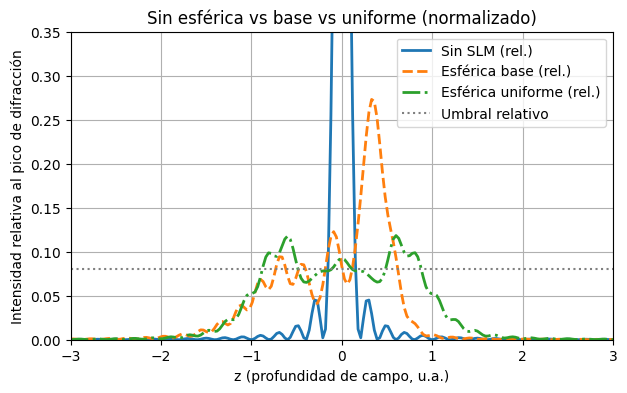

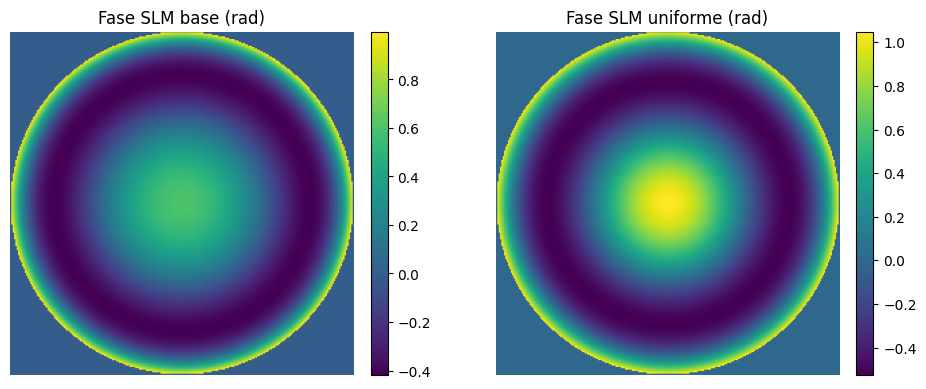

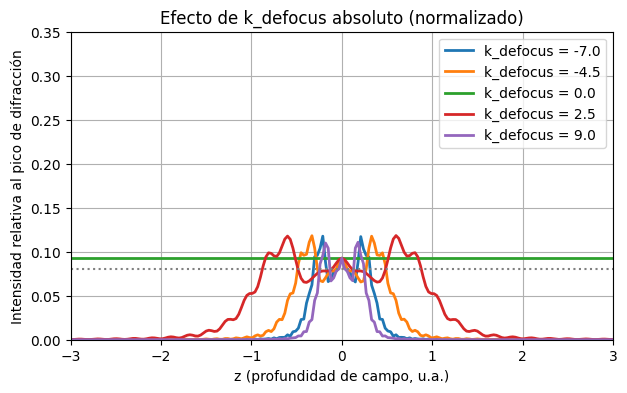

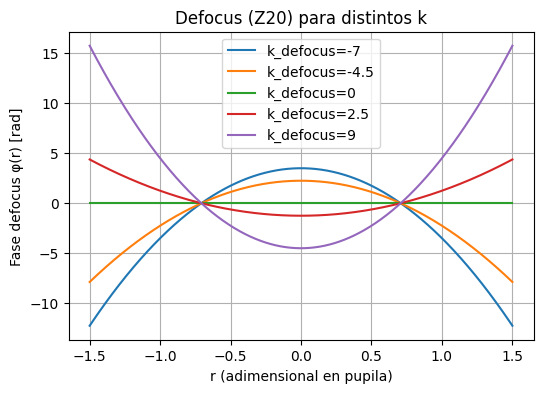

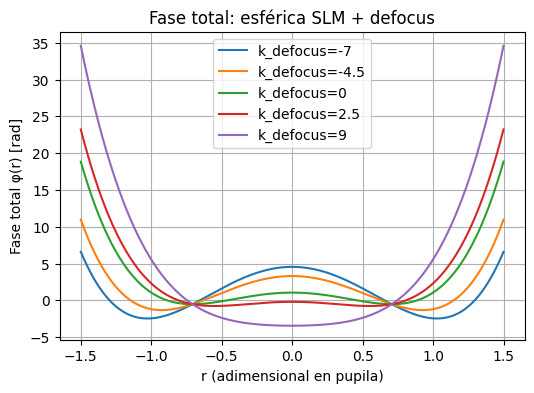


Áreas (máscaras plana vs Z40 vs Z60), umbral relativo 8.0% del pico Airy:
  Plana: 4.618e+08 | Z40: 4.000e+08 | Z60: 4.065e+08


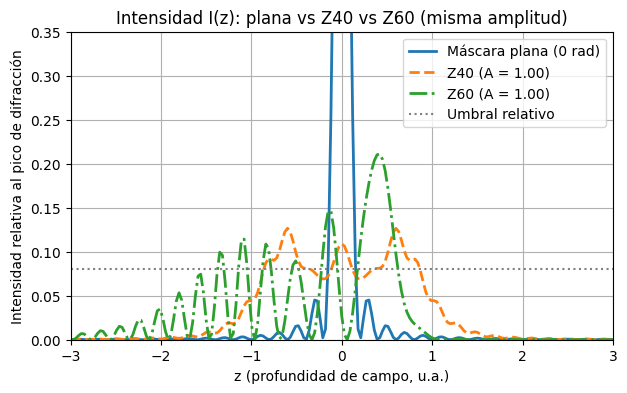


[Tips] Cambia arriba:
  - k_defocus (sistema), a4_base/a6_base (comparación), umbral_relativo, z_full/z_opt
  - Lista k_defocus_vals para el barrido
  - A_masc para la comparación plana vs Z40/Z60


/tmp/ipython-input-575097910.py:283: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(); plt.show()


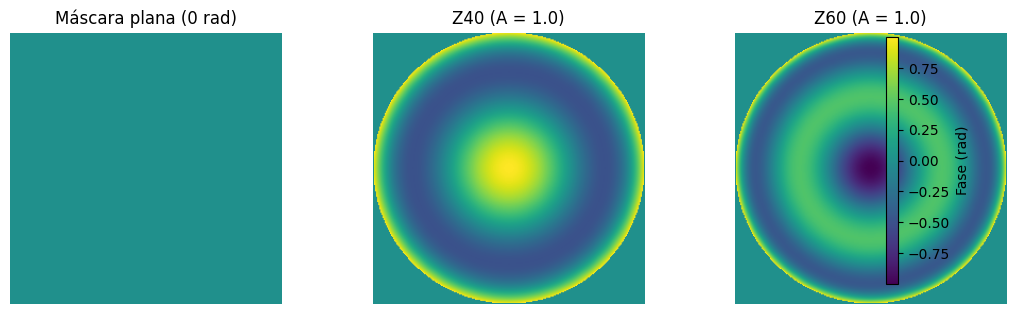

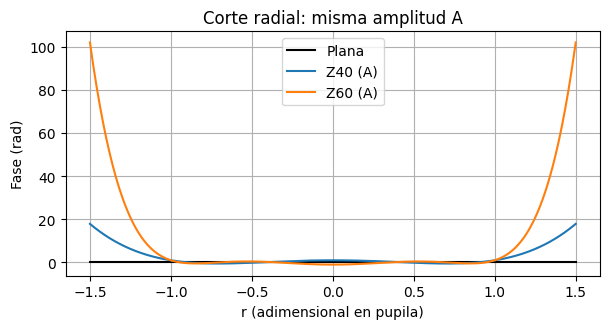

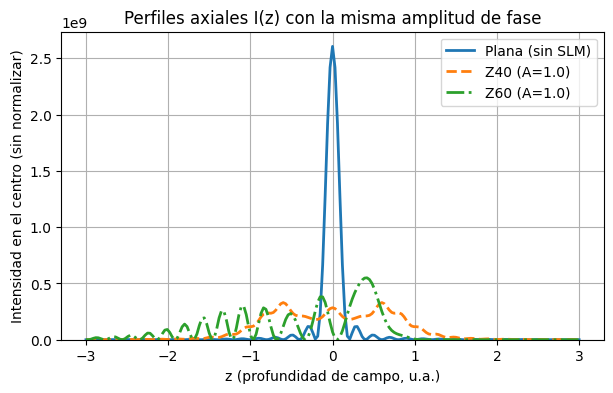

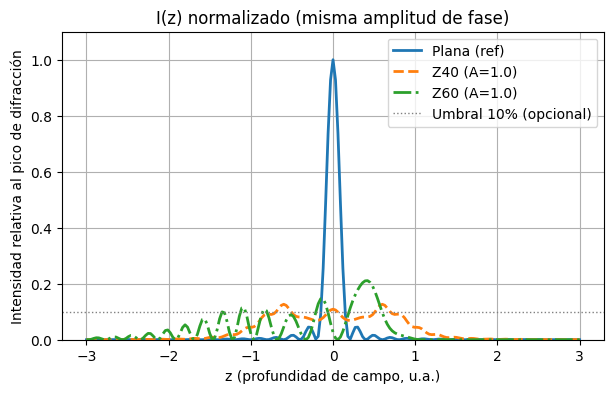

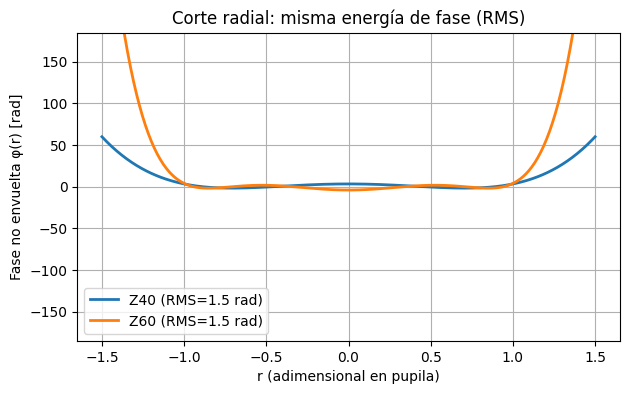

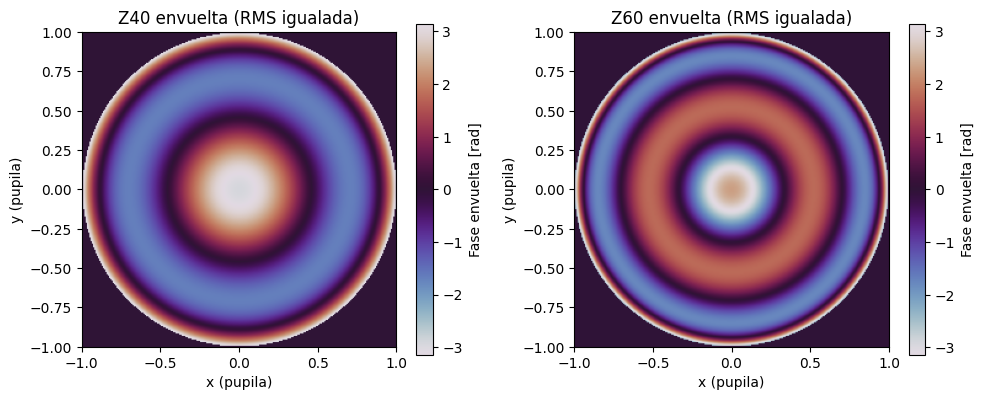

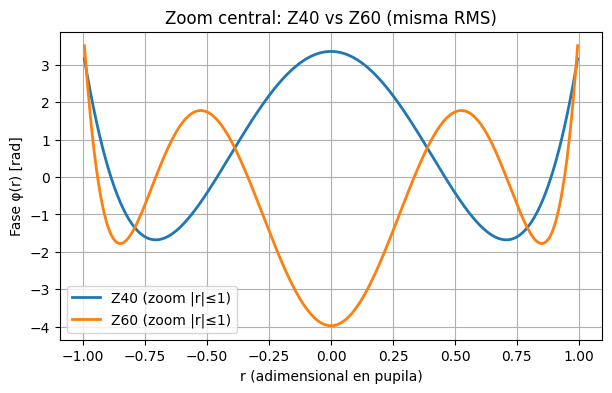

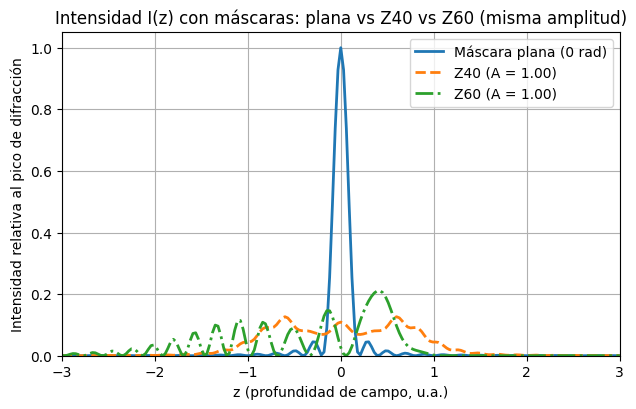

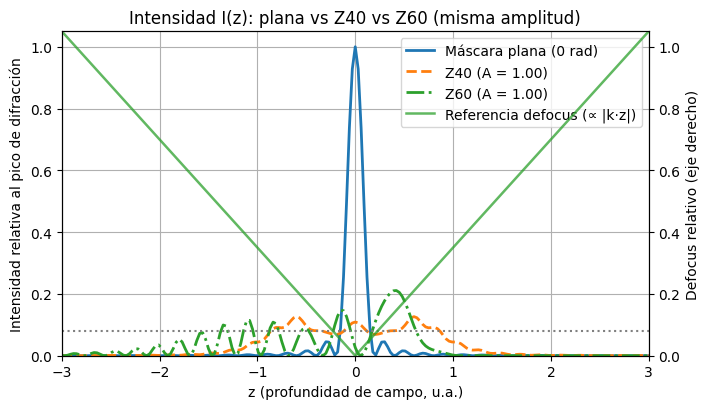

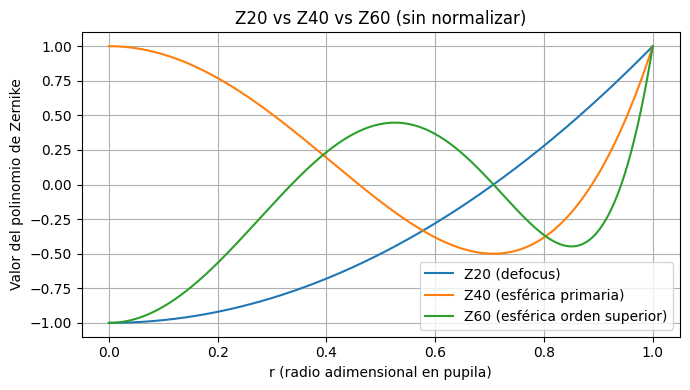

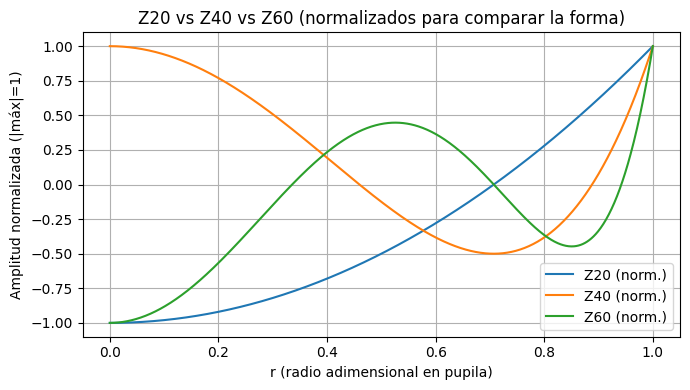

  Z20:  4.511e+08  (área sobre el umbral)


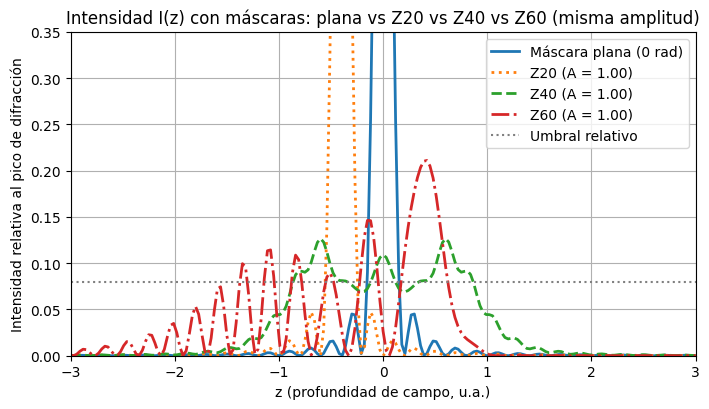

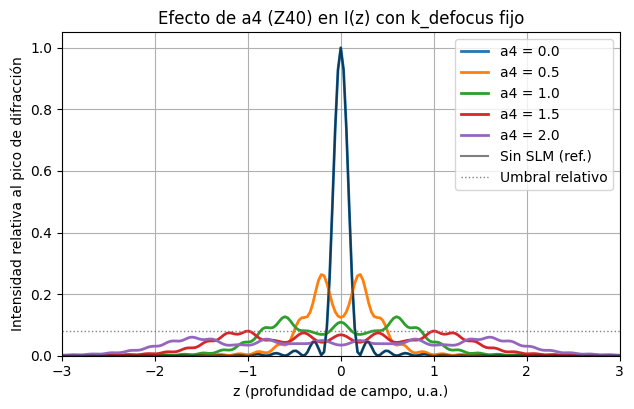

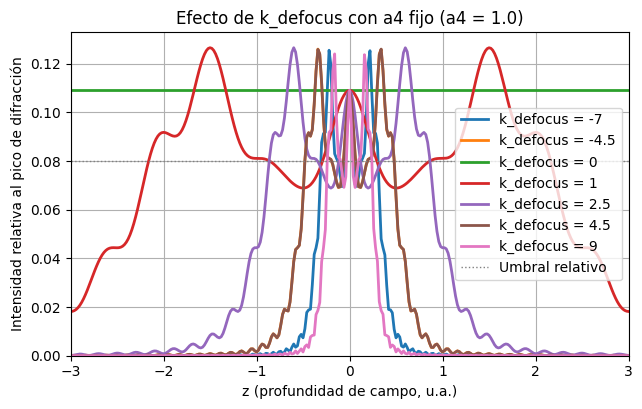

In [ ]:
# ============================================
#  Proyecto: EDOF con SLM y Zernike (script maestro)
#  Colab/Notebook friendly
# ============================================

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# ============================================
# 0) PARÁMETROS AJUSTABLES
# ============================================
# Geometría / muestreo
N_opt   = 96
N_full  = 256
R_pupila = 1.0
z_full  = np.linspace(-3.0, 3.0, 201)   # eje z para gráficas principales
z_opt   = np.linspace(-2.0, 2.0, 41)    # eje z para optimización (más corto)

# Defocus del SISTEMA base (se usa en casi todo el script)
k_defocus = 2.5

# Esférica "base" (no uniforme) para comparar
a4_base, a6_base = 0.8, 0.2

# Umbral para integrar áreas (relativo al pico Airy del sistema sin SLM)
umbral_relativo = 0.08   # p.ej. 8%

# Para pruebas de k_defocus ABSOLUTO (segunda figura de defocus)
k_defocus_vals = [-7.0, -4.5, 0.0, 2.5, 9.0]

# Para el inciso de máscaras plana vs Z40 vs Z60 (misma amplitud)
A_masc = 1.0

# ============================================
# 1) ZERNIKE (n, m) con m=0: defocus y esféricas
# ============================================
def Z20(r):  # Defocus (n=2, m=0)
    return 2*r**2 - 1

def Z40(r):  # Esférica primaria (n=4, m=0)
    return 6*r**4 - 6*r**2 + 1

def Z60(r):  # Esférica de orden superior (n=6, m=0)
    return 20*r**6 - 30*r**4 + 12*r**2 - 1

# ============================================
# 2) Pupila y utilidades
# ============================================
def prepara_pupila(N, R=1.0):
    x = np.linspace(-R, R, N)
    y = np.linspace(-R, R, N)
    X, Y = np.meshgrid(x, y)
    Rm   = np.sqrt(X**2 + Y**2)
    apertura = (Rm <= 1.0).astype(float)
    return Rm, apertura

R_opt,  apertura_opt  = prepara_pupila(N_opt,  R_pupila)
R_full, apertura_full = prepara_pupila(N_full, R_pupila)

# ============================================
# 3) Perfil axial I(z)
#    Fase total en pupila: phi = a4 Z40 + a6 Z60 + k_defocus*z*Z20
# ============================================
# 3) Perfil axial I(z)
#    Fase total: phi = a4 Z40 + a6 Z60 + k_defocus_local*z*Z20
def perfil_axial(R, apertura, z_array, a4_slm, a6_slm, k_defocus_local=None):
    # Si no te dieron k_defocus_local, usa el global k_defocus
    if k_defocus_local is None:
        k_defocus_local = k_defocus

    I_z = []
    phi_slm = a4_slm * Z40(R) + a6_slm * Z60(R)
    for z in z_array:
        phi = phi_slm + k_defocus_local * z * Z20(R)
        pupil = apertura * np.exp(1j * 2*np.pi * phi)
        campo = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(pupil)))
        I    = np.abs(campo)**2
        cy, cx = I.shape[0]//2, I.shape[1]//2
        I_z.append(I[cy, cx])
    return np.array(I_z)


# ============================================
# 4) Coste para "esférica uniforme" (top-hat en ventana z)
# ============================================
def coste_uniforme(params):
    a4_slm, a6_slm = params
    I = perfil_axial(R_opt, apertura_opt, z_opt, a4_slm, a6_slm, k_defocus)
    z_min, z_max = -0.5, 0.5
    idx = (z_opt >= z_min) & (z_opt <= z_max)
    I_roi = I[idx]
    if I_roi.mean() == 0:
        return 1e9
    I_norm = I_roi / I_roi.mean()
    return np.mean((I_norm - 1.0)**2)

# ============================================
# 5) Perfiles base / optimización / sin SLM
# ============================================
# Sin SLM (Airy puro del sistema con mismo muestreo)
I_sin_slm = perfil_axial(R_full, apertura_full, z_full, 0.0, 0.0, k_defocus)

# Esférica base (no uniforme)
I_base = perfil_axial(R_full, apertura_full, z_full, a4_base, a6_base, k_defocus)

# Optimización (a4,a6) para uniforme
res = minimize(coste_uniforme, x0=np.array([a4_base, a6_base]),
               method='Nelder-Mead', options={'maxiter': 80, 'disp': False})
a4_uni, a6_uni = res.x

# Esférica uniforme (SLM óptimo)
I_unif = perfil_axial(R_full, apertura_full, z_full, a4_uni, a6_uni, k_defocus)

print(f"[Optimización] a4_uni = {a4_uni:.4f}, a6_uni = {a6_uni:.4f}")

# ============================================
# 6) Normalización FÍSICA y área bajo la curva
#     -> todo relativo al pico Airy del sistema sin SLM
# ============================================
I_airy_peak = I_sin_slm.max()
def rel(I): return I / I_airy_peak

thr_abs = umbral_relativo * I_airy_peak

def area_con_umbral(z, I, thr):
    mask = (I >= thr)
    if np.count_nonzero(mask) < 2:
        return 0.0
    i0, i1 = np.where(mask)[0][[0, -1]]
    return np.trapz(I[i0:i1+1], z[i0:i1+1])

A_sin  = area_con_umbral(z_full, I_sin_slm, thr_abs)
A_base = area_con_umbral(z_full, I_base,    thr_abs)
A_unif = area_con_umbral(z_full, I_unif,    thr_abs)

print("\nÁreas por encima del umbral (unidades relativas z·intensidad):")
print(f"  Sin SLM      : {A_sin:.3e}")
print(f"  Esférica base: {A_base:.3e}")
print(f"  Esférica unif: {A_unif:.3e}")

# Límites comunes para y (normalizado)
ymin_rel, ymax_rel = 0.0, 0.35   # <- ajusta si deseas más/menos rango

# ============================================
# 7) GRÁFICAS comparativas (normalizadas)
# ============================================
plt.figure(figsize=(7,4))
plt.plot(z_full, rel(I_sin_slm),  '-',  lw=2, label='Sin SLM (rel.)')
plt.plot(z_full, rel(I_base),     '--', lw=2, label='Esférica base (rel.)')
plt.plot(z_full, rel(I_unif),     '-.', lw=2, label='Esférica uniforme (rel.)')
plt.axhline(umbral_relativo, color='gray', ls=':', label='Umbral relativo')
plt.xlabel('z (profundidad de campo, u.a.)')
plt.ylabel('Intensidad relativa al pico de difracción')
plt.title('Sin esférica vs base vs uniforme (normalizado)')
plt.grid(True); plt.legend()
plt.ylim(ymin_rel, ymax_rel); plt.xlim(z_full.min(), z_full.max())
plt.show()

# ============================================
# 8) Mapa de fase del SLM (base vs uniforme)
# ============================================
def fase_slm(R, a4, a6): return a4*Z40(R) + a6*Z60(R)

phi_base = fase_slm(R_full, a4_base, a6_base)*apertura_full
phi_unif = fase_slm(R_full, a4_uni,  a6_uni )*apertura_full

fig, axs = plt.subplots(1,2, figsize=(10,4))
im0 = axs[0].imshow(phi_base, origin='lower', cmap='viridis'); axs[0].axis('off')
axs[0].set_title('Fase SLM base (rad)');  plt.colorbar(im0, ax=axs[0], fraction=0.046, pad=0.04)
im1 = axs[1].imshow(phi_unif, origin='lower', cmap='viridis'); axs[1].axis('off')
axs[1].set_title('Fase SLM uniforme (rad)'); plt.colorbar(im1, ax=axs[1], fraction=0.046, pad=0.04)
plt.tight_layout(); plt.show()

# ============================================
# 9) Pruebas con k_defocus ABSOLUTO (misma esférica uniforme)
# ============================================
plt.figure(figsize=(7,4))
for k_loc in k_defocus_vals:
    I_k = perfil_axial(R_full, apertura_full, z_full, a4_uni, a6_uni, k_loc)
    plt.plot(z_full, rel(I_k), lw=2, label=f'k_defocus = {k_loc:.1f}')
plt.axhline(umbral_relativo, color='gray', ls=':')
plt.xlabel('z (profundidad de campo, u.a.)')
plt.ylabel('Intensidad relativa al pico de difracción')
plt.title('Efecto de k_defocus absoluto (normalizado)')
plt.grid(True); plt.legend()
plt.ylim(ymin_rel, ymax_rel); plt.xlim(z_full.min(), z_full.max())
plt.show()

# ============================================
# 10) Cortes 1D en pupila: defocus y total (ilustrativos)
# ============================================
r_1d = np.linspace(-1.5, 1.5, 600)
Z20_1d, Z40_1d, Z60_1d = Z20(r_1d), Z40(r_1d), Z60(r_1d)
z0 = 0.5
plt.figure(figsize=(6,4))
for k in [-7, -4.5, 0, 2.5, 9]:
    plt.plot(r_1d, k*z0*Z20_1d, label=f'k_defocus={k}')
plt.xlabel('r (adimensional en pupila)'); plt.ylabel('Fase defocus φ(r) [rad]')
plt.title('Defocus (Z20) para distintos k'); plt.grid(True); plt.legend(); plt.show()

phi_slm_uni_1d = a4_uni*Z40_1d + a6_uni*Z60_1d
plt.figure(figsize=(6,4))
for k in [-7, -4.5, 0, 2.5, 9]:
    plt.plot(r_1d, phi_slm_uni_1d + k*z0*Z20_1d, label=f'k_defocus={k}')
plt.xlabel('r (adimensional en pupila)'); plt.ylabel('Fase total φ(r) [rad]')
plt.title('Fase total: esférica SLM + defocus'); plt.grid(True); plt.legend(); plt.show()

# ============================================
# 11) Inciso: máscaras plana vs Z40 vs Z60 (misma amplitud)
#      + ÁREA por encima de umbral relativo
# ============================================
def perfil_axial_solo_mascara(R, apertura, z_array, phi_mask, k_loc):
    I_z = []
    for z in z_array:
        phi = phi_mask + k_loc * z * Z20(R)
        pupil = apertura * np.exp(1j * 2*np.pi * phi)
        campo = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(pupil)))
        I    = np.abs(campo)**2
        cy, cx = I.shape[0]//2, I.shape[1]//2
        I_z.append(I[cy, cx])
    return np.array(I_z)

phi_plana = np.zeros_like(R_full)
phi_Z40   = A_masc * Z40(R_full) * apertura_full
phi_Z60   = A_masc * Z60(R_full) * apertura_full

I_plana = perfil_axial_solo_mascara(R_full, apertura_full, z_full, phi_plana, k_defocus)
I_Z40   = perfil_axial_solo_mascara(R_full, apertura_full, z_full, phi_Z40,   k_defocus)
I_Z60   = perfil_axial_solo_mascara(R_full, apertura_full, z_full, phi_Z60,   k_defocus)

A_plana = area_con_umbral(z_full, I_plana, thr_abs)
A_Z40   = area_con_umbral(z_full, I_Z40,  thr_abs)
A_Z60   = area_con_umbral(z_full, I_Z60,  thr_abs)

print("\nÁreas (máscaras plana vs Z40 vs Z60), umbral relativo "
      f"{umbral_relativo*100:.1f}% del pico Airy:")
print(f"  Plana: {A_plana:.3e} | Z40: {A_Z40:.3e} | Z60: {A_Z60:.3e}")

plt.figure(figsize=(7,4))
plt.plot(z_full, rel(I_plana), '-',  lw=2, label='Máscara plana (0 rad)')
plt.plot(z_full, rel(I_Z40),   '--', lw=2, label=f'Z40 (A = {A_masc:.2f})')
plt.plot(z_full, rel(I_Z60),   '-.', lw=2, label=f'Z60 (A = {A_masc:.2f})')
plt.axhline(umbral_relativo, color='gray', ls=':', label='Umbral relativo')
plt.xlabel('z (profundidad de campo, u.a.)')
plt.ylabel('Intensidad relativa al pico de difracción')
plt.title('Intensidad I(z): plana vs Z40 vs Z60 (misma amplitud)')
plt.grid(True); plt.legend()
plt.ylim(ymin_rel, ymax_rel); plt.xlim(z_full.min(), z_full.max())
plt.show()

# ============================================
# 12) PUNTOS DE CONTROL (para jugar con parámetros)
#     - Cambiar a4_base/a6_base, k_defocus
#     - Cambiar umbral_relativo o rangos de z
#     - Cambiar A_masc (amplitud Z40/Z60 en el inciso)
# ============================================
print("\n[Tips] Cambia arriba:")
print("  - k_defocus (sistema), a4_base/a6_base (comparación), umbral_relativo, z_full/z_opt")
print("  - Lista k_defocus_vals para el barrido")
print("  - A_masc para la comparación plana vs Z40/Z60")


# --- Comparación de fase con la MISMA amplitud A ---
A = 1.0  # misma amplitud para Z40 y Z60

# Mapa 2D (misma escala de color para comparación justa)
phi_flat = 0.0 * apertura_full
phi_z40  = A * Z40(R_full) * apertura_full
phi_z60  = A * Z60(R_full) * apertura_full

vmax = max(np.abs(phi_z40).max(), np.abs(phi_z60).max())
vmin = -vmax

fig, axs = plt.subplots(1, 3, figsize=(11, 3.2))
im0 = axs[0].imshow(phi_flat, origin='lower', cmap='viridis', vmin=vmin, vmax=vmax)
axs[0].set_title('Máscara plana (0 rad)'); axs[0].axis('off')
im1 = axs[1].imshow(phi_z40, origin='lower', cmap='viridis', vmin=vmin, vmax=vmax)
axs[1].set_title('Z40 (A = {:.1f})'.format(A)); axs[1].axis('off')
im2 = axs[2].imshow(phi_z60, origin='lower', cmap='viridis', vmin=vmin, vmax=vmax)
axs[2].set_title('Z60 (A = {:.1f})'.format(A)); axs[2].axis('off')
plt.colorbar(im2, ax=axs, fraction=0.03, pad=0.02, label='Fase (rad)')
plt.tight_layout(); plt.show()

# Corte radial 1D en la misma amplitud
r_1d = np.linspace(-1.5, 1.5, 600)
plt.figure(figsize=(6.2, 3.4))
plt.plot(r_1d, 0*r_1d, 'k-',  label='Plana')
plt.plot(r_1d, A*Z40(r_1d),  label='Z40 (A)')
plt.plot(r_1d, A*Z60(r_1d),  label='Z60 (A)')
plt.xlabel('r (adimensional en pupila)'); plt.ylabel('Fase (rad)')
plt.title('Corte radial: misma amplitud A')
plt.grid(True); plt.legend(); plt.tight_layout(); plt.show()

# --- Perfiles axiales en z con MISMA amplitud A para comparar forma ---
A = 1.0  # misma amplitud para Z40 y Z60 (ajústala si quieres explorar)

# 1) Definimos una envolvente de fase para cada caso
def I_z_mask(a4, a6):
    return perfil_axial(R_full, apertura_full, z_full, a4_slm=a4, a6_slm=a6)

I_flat = I_z_mask(0.0, 0.0)       # máscara plana (sin SLM)
I_Z40  = I_z_mask(A,   0.0)       # solo Z40 con amplitud A
I_Z60  = I_z_mask(0.0, A)         # solo Z60 con amplitud A

# 2) Mismos ejes (intensidad bruta)
Imax = np.max([I_flat.max(), I_Z40.max(), I_Z60.max()])

plt.figure(figsize=(7,4))
plt.plot(z_full, I_flat, '-',  lw=2, label='Plana (sin SLM)')
plt.plot(z_full, I_Z40,  '--', lw=2, label=f'Z40 (A={A})')
plt.plot(z_full, I_Z60,  '-.', lw=2, label=f'Z60 (A={A})')
plt.xlabel('z (profundidad de campo, u.a.)')
plt.ylabel('Intensidad en el centro (sin normalizar)')
plt.title('Perfiles axiales I(z) con la misma amplitud de fase')
plt.grid(True); plt.legend()
plt.ylim(0, 1.05*Imax)
plt.show()

# 3) Curvas normalizadas al pico de difracción (para comparar solo la forma)
I0 = I_flat.max()  # pico de referencia (sin SLM)
plt.figure(figsize=(7,4))
plt.plot(z_full, I_flat/I0, '-',  lw=2, label='Plana (ref)')
plt.plot(z_full, I_Z40/I0,  '--', lw=2, label=f'Z40 (A={A})')
plt.plot(z_full, I_Z60/I0,  '-.', lw=2, label=f'Z60 (A={A})')
plt.axhline(0.1, color='gray', ls=':', lw=1, label='Umbral 10% (opcional)')
plt.xlabel('z (profundidad de campo, u.a.)')
plt.ylabel('Intensidad relativa al pico de difracción')
plt.title('I(z) normalizado (misma amplitud de fase)')
plt.grid(True); plt.legend()
plt.ylim(0, 1.1*max((I_Z40/I0).max(), (I_Z60/I0).max(), 1.0))
plt.show()

# =========================================================
# Comparación justa Z40 vs Z60: misma energía (RMS) en pupila
# y vistas: no envuelta / envuelta / zoom central
# =========================================================

def rms_fase_sobre_apertura(phi2d, aperture):
    w = aperture.astype(float)
    m = (phi2d*w).sum() / w.sum()                    # media (por si quisieras quitarla)
    rms = np.sqrt(((phi2d - m)**2 * w).sum() / w.sum())
    return rms

# Objetivo: misma RMS de fase (en rad) para ambas máscaras
target_rms = 1.5  # prueba con 1.0–2.0 rad si quieres más/menos contraste

# Construye Z40 y Z60 en 2D y calcula escalas A40, A60 para igualar RMS
Z40_2d = Z40(R_full) * apertura_full
Z60_2d = Z60(R_full) * apertura_full

# RMS con amplitud 1
rms40_1 = rms_fase_sobre_apertura(Z40_2d, apertura_full)
rms60_1 = rms_fase_sobre_apertura(Z60_2d, apertura_full)

A40 = target_rms / (rms40_1 + 1e-12)
A60 = target_rms / (rms60_1 + 1e-12)

# Cortes radiales 1D (coherentes con el 2D)
r_1d = np.linspace(-1.5, 1.5, 500)
phi40_1d = A40 * Z40(r_1d)
phi60_1d = A60 * Z60(r_1d)

# -------- 1) Fase NO envuelta (mismo RMS, eje acotado) --------
plt.figure(figsize=(7,4))
plt.plot(r_1d, phi40_1d, lw=2, label=f'Z40 (RMS={target_rms:.1f} rad)')
plt.plot(r_1d, phi60_1d, lw=2, label=f'Z60 (RMS={target_rms:.1f} rad)')
plt.xlabel('r (adimensional en pupila)')
plt.ylabel('Fase no envuelta φ(r) [rad]')
plt.title('Corte radial: misma energía de fase (RMS)')
plt.grid(True); plt.legend()
# Acota para ver detalles (quita el tope si quieres toda la amplitud)
ylim = np.percentile(np.abs(np.r_[phi40_1d,phi60_1d]), 95)
plt.ylim(-1.1*ylim, 1.1*ylim)
plt.show()

# -------- 2) Fase ENVUELTA (mod 2π) en 2D para ver estructura --------
def mostrar_fase_envuelta(phi2d, title):
    phi_wrap = np.angle(np.exp(1j*phi2d))  # wrap a (-π, π]
    im = plt.imshow(phi_wrap*apertura_full, origin='lower', cmap='twilight',
                    extent=[-1,1,-1,1])
    plt.title(title); plt.xlabel('x (pupila)'); plt.ylabel('y (pupila)')
    cbar = plt.colorbar(im); cbar.set_label('Fase envuelta [rad]')

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
mostrar_fase_envuelta(A40*Z40_2d, 'Z40 envuelta (RMS igualada)')
plt.subplot(1,2,2)
mostrar_fase_envuelta(A60*Z60_2d, 'Z60 envuelta (RMS igualada)')
plt.tight_layout(); plt.show()

# -------- 3) Zoom central (|r| ≤ 1) para resaltar curvatura --------
mask_zoom = (np.abs(r_1d) <= 1.0)
plt.figure(figsize=(7,4))
plt.plot(r_1d[mask_zoom], phi40_1d[mask_zoom], lw=2, label='Z40 (zoom |r|≤1)')
plt.plot(r_1d[mask_zoom], phi60_1d[mask_zoom], lw=2, label='Z60 (zoom |r|≤1)')
plt.xlabel('r (adimensional en pupila)'); plt.ylabel('Fase φ(r) [rad]')
plt.title('Zoom central: Z40 vs Z60 (misma RMS)')
plt.grid(True); plt.legend()
plt.show()


# ================================
# Intensidad I(z): plana vs Z40(A) vs Z60(A)
# ================================

A_amp = 1.0          # amplitud común para Z40 y Z60 (ajústala para ver diferencias)
# k_defocus ya existe como constante global del sistema (por defecto 2.5).
# Si quieres otro, cámbialo ANTES de correr este bloque.

# 1) Máscara plana (sin fase SLM)
I_flat = perfil_axial(R_full, apertura_full, z_full, a4_slm=0.0,    a6_slm=0.0)

# 2) Z40 con amplitud A (esférica primaria)
I_z40  = perfil_axial(R_full, apertura_full, z_full, a4_slm=A_amp,  a6_slm=0.0)

# 3) Z60 con amplitud A (esférica de orden superior)
I_z60  = perfil_axial(R_full, apertura_full, z_full, a4_slm=0.0,    a6_slm=A_amp)

# --- Normalización relativa al máximo del caso plano (pico de difracción)
I_Airy_max = I_flat.max()
I_flat_rel = I_flat / I_Airy_max
I_z40_rel  = I_z40  / I_Airy_max
I_z60_rel  = I_z60  / I_Airy_max

# --- Gráfica comparativa con mismos ejes
plt.figure(figsize=(7.2, 4.2))
plt.plot(z_full, I_flat_rel, '-',  lw=2, label='Máscara plana (0 rad)')
plt.plot(z_full, I_z40_rel,  '--', lw=2, label=f'Z40 (A = {A_amp:.2f})')
plt.plot(z_full, I_z60_rel,  '-.', lw=2, label=f'Z60 (A = {A_amp:.2f})')

plt.xlabel('z (profundidad de campo, u.a.)')
plt.ylabel('Intensidad relativa al pico de difracción')
plt.title('Intensidad I(z) con máscaras: plana vs Z40 vs Z60 (misma amplitud)')
plt.grid(True)
plt.legend()

# Ejes consistentes con el resto del cuaderno
plt.xlim(z_full.min(), z_full.max())
plt.ylim(0, max(I_flat_rel.max(), I_z40_rel.max(), I_z60_rel.max()) * 1.05)
plt.show()

# ================================
# Intensidad I(z): plana vs Z40(A) vs Z60(A)
# + umbral y referencia de defocus (Z20) en eje derecho
# ================================

A_amp = 1.0  # amplitud común para Z40 y Z60

# 1) Perfiles con la fase en pupila: phi = a4 Z40 + a6 Z60 + k_defocus*z*Z20
I_flat = perfil_axial(R_full, apertura_full, z_full, a4_slm=0.0,   a6_slm=0.0,   k_defocus_local=k_defocus)
I_z40  = perfil_axial(R_full, apertura_full, z_full, a4_slm=A_amp, a6_slm=0.0,   k_defocus_local=k_defocus)
I_z60  = perfil_axial(R_full, apertura_full, z_full, a4_slm=0.0,   a6_slm=A_amp, k_defocus_local=k_defocus)

# 2) Normalización relativa al pico Airy del caso plano (misma referencia física)
I_Airy_max = I_flat.max()
I_flat_rel = I_flat / I_Airy_max
I_z40_rel  = I_z40  / I_Airy_max
I_z60_rel  = I_z60  / I_Airy_max

# 3) Figura con umbral (eje izquierdo) + referencia "Z20" (eje derecho)
fig, ax = plt.subplots(figsize=(7.2, 4.2))

# Curvas de intensidad (eje izquierdo)
h0, = ax.plot(z_full, I_flat_rel, '-',  lw=2, label='Máscara plana (0 rad)')
h1, = ax.plot(z_full, I_z40_rel,  '--', lw=2, label=f'Z40 (A = {A_amp:.2f})')
h2, = ax.plot(z_full, I_z60_rel,  '-.', lw=2, label=f'Z60 (A = {A_amp:.2f})')

# Umbral relativo (mismo que en otras figuras)
ax.axhline(umbral_relativo, color='gray', ls=':', lw=1.5, label='Umbral relativo')

ax.set_xlabel('z (profundidad de campo, u.a.)')
ax.set_ylabel('Intensidad relativa al pico de difracción')
ax.set_title('Intensidad I(z): plana vs Z40 vs Z60 (misma amplitud)')
ax.grid(True)

# Límites coherentes
ax.set_xlim(z_full.min(), z_full.max())
ymax_fig = max(I_flat_rel.max(), I_z40_rel.max(), I_z60_rel.max(), umbral_relativo) * 1.05
ax.set_ylim(0, ymax_fig)

# --- EJE DERECHO: referencia de defocus (Z20) ---
# Nota: Z20 es función de r; para dar una guía sobre “cuánta” fase de defocus hay a lo largo de z,
# mostramos una métrica proporcional a |k_defocus * z|, reescalada al rango del eje izquierdo.
ax2 = ax.twinx()
defocus_rel = np.abs(k_defocus * z_full)          # amplitud relativa de defocus vs z
# normalizamos 0..1 y lo llevamos al rango del eje izquierdo para que se lea junto
defocus_rel = defocus_rel / (defocus_rel.max() + 1e-12) * ymax_fig

h3, = ax2.plot(z_full, defocus_rel, color='tab:green', lw=1.8, alpha=0.75,
               label='Referencia defocus (∝ |k·z|)')
ax2.set_ylim(0, ymax_fig)
ax2.set_ylabel('Defocus relativo (eje derecho)')

# Leyenda combinada (ejes izquierdo y derecho)
handles = [h0, h1, h2, h3]
labels  = [h.get_label() for h in handles]
ax.legend(handles, labels, loc='upper right')

plt.tight_layout()
plt.show()


# ============================
# Z20 vs Z40 vs Z60 en 1 sola figura
# (corte radial y versión normalizada)
# ============================

# Corte radial solo de 0→1 (radio de la pupila)
r_1d = np.linspace(0, 1.0, 1000)

P20 = Z20(r_1d)   # defocus
P40 = Z40(r_1d)   # esférica primaria
P60 = Z60(r_1d)   # esférica de orden superior

# --- 1) Curvas sin normalizar (valores "reales" de los polinomios) ---
import matplotlib.pyplot as plt
plt.figure(figsize=(7,4))
plt.plot(r_1d, P20, label='Z20 (defocus)')
plt.plot(r_1d, P40, label='Z40 (esférica primaria)')
plt.plot(r_1d, P60, label='Z60 (esférica orden superior)')
plt.xlabel('r (radio adimensional en pupila)')
plt.ylabel('Valor del polinomio de Zernike')
plt.title('Z20 vs Z40 vs Z60 (sin normalizar)')
plt.grid(True); plt.legend(); plt.tight_layout()
plt.show()

# --- 2) Curvas normalizadas por su máximo absoluto (para comparar solo la forma) ---
P20n = P20/np.max(np.abs(P20))
P40n = P40/np.max(np.abs(P40))
P60n = P60/np.max(np.abs(P60))

plt.figure(figsize=(7,4))
plt.plot(r_1d, P20n, label='Z20 (norm.)')
plt.plot(r_1d, P40n, label='Z40 (norm.)')
plt.plot(r_1d, P60n, label='Z60 (norm.)')
plt.xlabel('r (radio adimensional en pupila)')
plt.ylabel('Amplitud normalizada (|máx|=1)')
plt.title('Z20 vs Z40 vs Z60 (normalizados para comparar la forma)')
plt.ylim(-1.1, 1.1)
plt.grid(True); plt.legend(); plt.tight_layout()
plt.show()


# --- Añadir comparación con máscara Z20 (defocus como máscara estática) ---

# 1) Máscara de Z20 con la misma amplitud A_masc usada para Z40/Z60
phi_Z20 = A_masc * Z20(R_full) * apertura_full

# 2) Perfil axial con esa máscara (recordatorio: el sistema ya incluye k_defocus*z*Z20)
I_Z20 = perfil_axial_solo_mascara(R_full, apertura_full, z_full, phi_Z20, k_defocus)

# 3) Áreas por encima del umbral absoluto (opcional, para cuantificar)
A_Z20 = area_con_umbral(z_full, I_Z20, thr_abs)
print(f"  Z20:  {A_Z20:.3e}  (área sobre el umbral)")

# 4) Normalizar todo respecto al pico Airy del caso plano (coherente con el resto)
I_Z20_rel = I_Z20 / I_Airy_max

# 5) Gráfica comparativa: plana vs Z20 vs Z40 vs Z60 (misma amplitud)
plt.figure(figsize=(7.2, 4.2))
plt.plot(z_full, I_plana / I_Airy_max, '-',  lw=2, label='Máscara plana (0 rad)')
plt.plot(z_full, I_Z20_rel,            ':',  lw=2, label=f'Z20 (A = {A_masc:.2f})')
plt.plot(z_full, I_Z40   / I_Airy_max, '--', lw=2, label=f'Z40 (A = {A_masc:.2f})')
plt.plot(z_full, I_Z60   / I_Airy_max, '-.', lw=2, label=f'Z60 (A = {A_masc:.2f})')

# Línea de umbral relativa (misma que usas en otras figuras)
plt.axhline(umbral_relativo, color='gray', ls=':', label='Umbral relativo')

plt.xlabel('z (profundidad de campo, u.a.)')
plt.ylabel('Intensidad relativa al pico de difracción')
plt.title('Intensidad I(z) con máscaras: plana vs Z20 vs Z40 vs Z60 (misma amplitud)')
plt.grid(True)
plt.legend()
plt.xlim(z_full.min(), z_full.max())
plt.ylim(ymin_rel, ymax_rel)
plt.tight_layout()
plt.show()


# ============================================
# Barrido de a4 (Z40) con k_defocus fijo
# ============================================

# Valores a explorar (puedes añadir negativos para ver asimetrías en z)
a4_vals = [0.0, 0.5, 1.0, 1.5, 2.0]   # rad (coeficiente de Z40)
a6_fijo = 0.0                         # Z60 apagado (solo Z40)

# Normalización relativa al pico Airy del sistema sin SLM
I_airy_peak = I_sin_slm.max()
def rel(I): return I / I_airy_peak
thr_rel = umbral_relativo  # misma referencia que en otras figuras

plt.figure(figsize=(7.2, 4.2))
for a4 in a4_vals:
    I_a4 = perfil_axial(R_full, apertura_full, z_full,
                        a4_slm=a4, a6_slm=a6_fijo,
                        k_defocus_local=k_defocus)
    plt.plot(z_full, rel(I_a4), lw=2, label=f'a4 = {a4:.1f}')

# Opcional: referencia del caso sin SLM
plt.plot(z_full, rel(I_sin_slm), color='k', lw=1.5, alpha=0.5, label='Sin SLM (ref.)')

# Umbral relativo (misma estética que tus otras figuras)
plt.axhline(thr_rel, color='gray', ls=':', lw=1, label='Umbral relativo')

plt.xlabel('z (profundidad de campo, u.a.)')
plt.ylabel('Intensidad relativa al pico de difracción')
plt.title('Efecto de a4 (Z40) en I(z) con k_defocus fijo')
plt.grid(True); plt.legend()
plt.xlim(z_full.min(), z_full.max())
plt.ylim(0, max(0.35, plt.gca().get_ylim()[1]))  # ajusta si quieres más margen
plt.show()


# ============================
# Barrido de k_defocus con a4 fijo (Z40)
# ============================

import numpy as np
import matplotlib.pyplot as plt

# --- Zernike m=0 relevantes ---
def Z20(r):  # defocus
    return 2*r**2 - 1

def Z40(r):  # esférica primaria
    return 6*r**4 - 6*r**2 + 1

# --- Pupila circular ---
def make_pupil(N=256, R=1.0):
    x = np.linspace(-R, R, N)
    y = np.linspace(-R, R, N)
    X, Y = np.meshgrid(x, y)
    Rm = np.sqrt(X**2 + Y**2)
    aperture = (Rm <= 1.0).astype(float)
    return Rm, aperture

# --- Perfil axial I(z) con a4 fijo y k_defocus local ---
def I_z_with(R, aperture, z_array, a4_fixed, k_defocus_local):
    Iz = []
    phi_slm = a4_fixed * Z40(R)                # esférica fija
    for z in z_array:
        phi = phi_slm + k_defocus_local * z * Z20(R)  # defocus que “mueve” el foco
        pupil = aperture * np.exp(1j * 2*np.pi * phi)
        field = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(pupil)))
        inten = np.abs(field)**2
        cy, cx = inten.shape[0]//2, inten.shape[1]//2
        Iz.append(inten[cy, cx])
    return np.array(Iz)

# ===== Parámetros =====
N        = 256
z_full   = np.linspace(-3.0, 3.0, 301)   # eje z
a4_fixed = 1.0                           # esférica fija (ajústalo si quieres)
k_vals   = [-7.0, -4.5, 0.0, 1.0, 2.5, 4.5, 9.0]  # barrido de defocus

# Pupila
R, A = make_pupil(N)

# Caso de referencia: sin SLM (para normalizar)
def I_z_no_slm(R, A, z_array, k_defocus_local):
    Iz = []
    for z in z_array:
        phi = k_defocus_local * z * Z20(R)     # solo defocus del sistema
        pupil = A * np.exp(1j * 2*np.pi * phi)
        field = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(pupil)))
        inten = np.abs(field)**2
        cy, cx = inten.shape[0]//2, inten.shape[1]//2
        Iz.append(inten[cy, cx])
    return np.array(Iz)

# Pico Airy para normalizar (usa k=0 como referencia)
I_ref = I_z_no_slm(R, A, z_full, k_defocus_local=0.0)
I_airy_peak = I_ref.max()

# ===== Barrido y gráfica =====
plt.figure(figsize=(7.2, 4.2))

for k in k_vals:
    I_k = I_z_with(R, A, z_full, a4_fixed=a4_fixed, k_defocus_local=k)
    plt.plot(z_full, I_k / I_airy_peak, lw=2, label=f'k_defocus = {k:g}')

# Línea de referencia del umbral (opcional)
umbral_rel = 0.08
plt.axhline(umbral_rel, color='gray', ls=':', lw=1, label='Umbral relativo')

plt.xlabel('z (profundidad de campo, u.a.)')
plt.ylabel('Intensidad relativa al pico de difracción')
plt.title(f'Efecto de k_defocus con a4 fijo (a4 = {a4_fixed})')
plt.grid(True)
plt.legend()
plt.xlim(z_full.min(), z_full.max())
plt.ylim(0, None)  # deja que la figura elija el máximo
plt.show()


def perfil_axial(R, apertura, z_array, a4_slm, a6_slm,
                 k_defocus_local, a2_static=0.0, z_shift=0.0):
    I_z = []
    phi_slm = a4_slm * Z40(R) + a6_slm * Z60(R)
    for z in z_array:
        phi = (phi_slm
               + (a2_static + k_defocus_local*(z - z_shift)) * Z20(R))
        pupil = apertura * np.exp(1j * 2*np.pi * phi)
        campo = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(pupil)))
        I    = np.abs(campo)**2
        cy, cx = I.shape[0]//2, I.shape[1]//2
        I_z.append(I[cy, cx])
    return np.array(I_z)





[Optimización] a4_uni = 1.0493, a6_uni = 0.0009

Áreas por encima del umbral (u. relativas z·intensidad):
  Sin SLM      : 4.618e+08
  Esférica base: 3.996e+08
  Esférica unif: 3.962e+08


/tmp/ipython-input-2340181038.py:132: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(I[i0:i1+1], z[i0:i1+1])


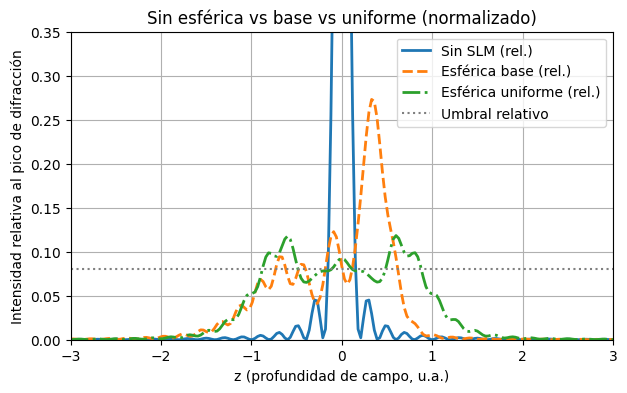

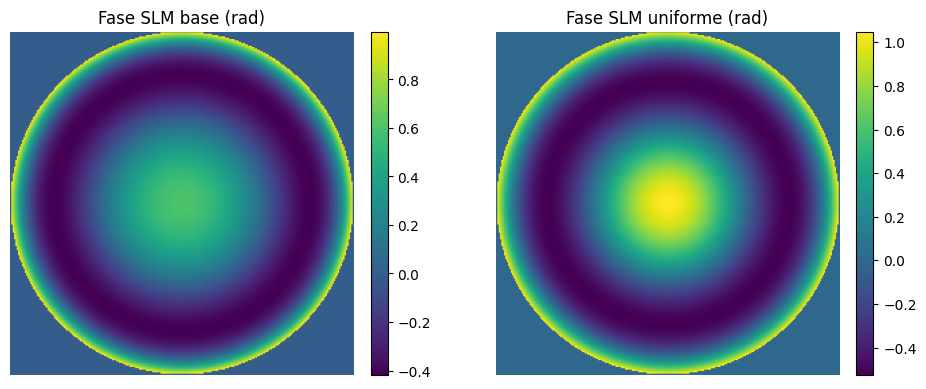

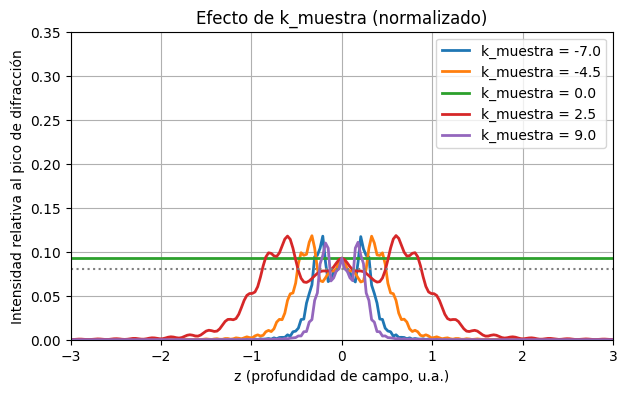

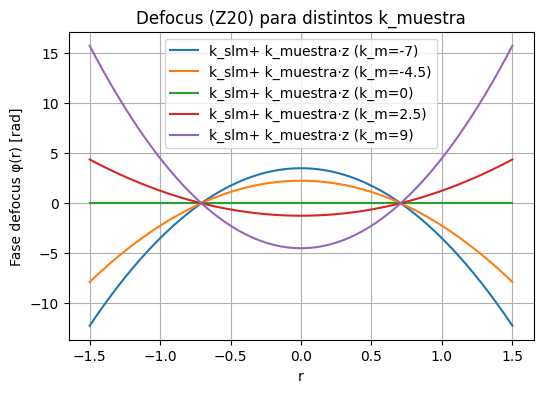

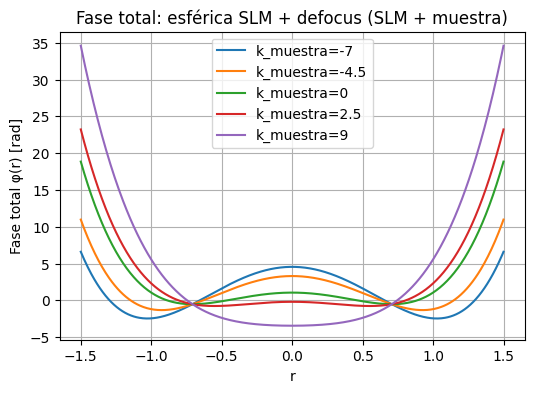


Áreas (plana vs Z40 vs Z60) sobre el umbral relativo:
  Plana: 4.618e+08 | Z40: 4.000e+08 | Z60: 4.065e+08


/tmp/ipython-input-2340181038.py:240: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(I[i0:i1+1], z[i0:i1+1])


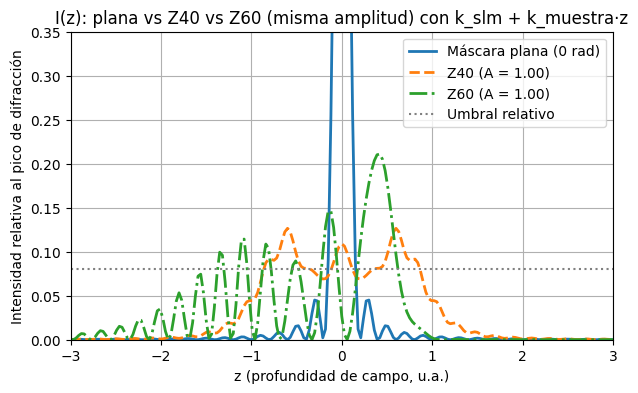

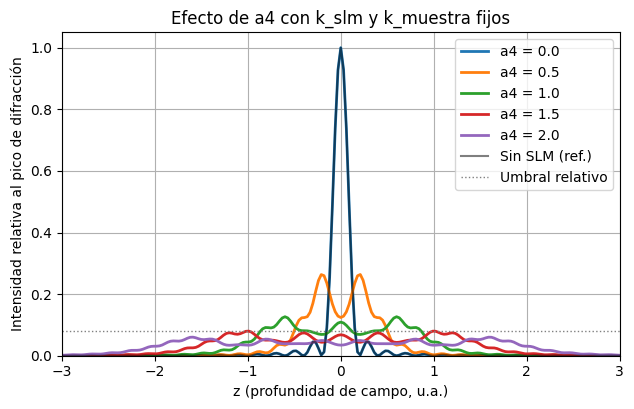

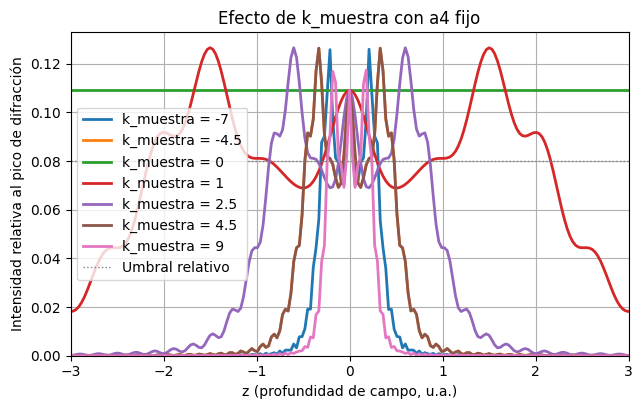

TypeError: perfil_axial() got an unexpected keyword argument 'k_defocus_local'

In [ ]:
# ============================================
#  Proyecto: EDOF con SLM y Zernike (script maestro)
#  Fase total: a4 Z40 + a6 Z60 + k_slm Z20 + k_muestra*z Z20
# ============================================

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# ============================================
# 0) PARÁMETROS AJUSTABLES
# ============================================
# Geometría / muestreo
N_opt   = 96
N_full  = 256
R_pupila = 1.0
z_full  = np.linspace(-3.0, 3.0, 201)   # eje z para gráficas principales
z_opt   = np.linspace(-2.0, 2.0, 41)    # eje z para optimización (más corto)

# Defocus (valores por defecto, cámbialos libremente)
k_slm_default     = 0.0   # defocus fijo (SLM)
k_muestra_default = 2.5   # defocus dependiente de z (muestra)

# Esférica "base" (no uniforme) para comparar
a4_base, a6_base = 0.8, 0.2

# Umbral para integrar áreas (relativo al pico Airy del caso sin SLM/SLM plano)
umbral_relativo = 0.08   # p.ej. 8%

# Para barridos de k_muestra
k_muestra_vals = [-7.0, -4.5, 0.0, 2.5, 9.0]

# Para el inciso de máscaras plana vs Z40 vs Z60 (misma amplitud)
A_masc = 1.0

# ============================================
# 1) ZERNIKE (n, m) con m=0
# ============================================
def Z20(r):  # Defocus (n=2, m=0)
    return 2*r**2 - 1

def Z40(r):  # Esférica primaria (n=4, m=0)
    return 6*r**4 - 6*r**2 + 1

def Z60(r):  # Esférica de orden superior (n=6, m=0)
    return 20*r**6 - 30*r**4 + 12*r**2 - 1

# ============================================
# 2) Pupila y utilidades
# ============================================
def prepara_pupila(N, R=1.0):
    x = np.linspace(-R, R, N)
    y = np.linspace(-R, R, N)
    X, Y = np.meshgrid(x, y)
    Rm   = np.sqrt(X**2 + Y**2)
    apertura = (Rm <= 1.0).astype(float)
    return Rm, apertura

R_opt,  apertura_opt  = prepara_pupila(N_opt,  R_pupila)
R_full, apertura_full = prepara_pupila(N_full, R_pupila)

# ============================================
# 3) Fase total y perfil axial I(z)
#     phi = a4 Z40 + a6 Z60 + k_slm Z20 + k_muestra*z Z20
# ============================================
def phi_total(R, z, a4, a6, k_slm, k_muestra):
    return a4*Z40(R) + a6*Z60(R) + (k_slm + k_muestra*z)*Z20(R)

def perfil_axial(R, apertura, z_array, a4_slm, a6_slm,
                 k_slm=k_slm_default, k_muestra=k_muestra_default):
    I_z = []
    for z in z_array:
        phi = phi_total(R, z, a4_slm, a6_slm, k_slm, k_muestra)
        pupil = apertura * np.exp(1j * 2*np.pi * phi)
        campo = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(pupil)))
        I    = np.abs(campo)**2
        cy, cx = I.shape[0]//2, I.shape[1]//2
        I_z.append(I[cy, cx])
    return np.array(I_z)

# ============================================
# 4) Coste para "esférica uniforme" (top-hat en ventana z)
#    (se usa el mismo k_slm/k_muestra durante la optimización)
# ============================================
def coste_uniforme(params, k_slm=k_slm_default, k_muestra=k_muestra_default):
    a4_slm, a6_slm = params
    I = perfil_axial(R_opt, apertura_opt, z_opt, a4_slm, a6_slm, k_slm, k_muestra)
    z_min, z_max = -0.5, 0.5
    idx = (z_opt >= z_min) & (z_opt <= z_max)
    I_roi = I[idx]
    if I_roi.mean() == 0:
        return 1e9
    I_norm = I_roi / I_roi.mean()
    return np.mean((I_norm - 1.0)**2)

# ============================================
# 5) Perfiles base / optimización / sin SLM (fase plana)
# ============================================
# Sin SLM (fase SLM=0) pero con defocus del sistema tomado como “muestra” si quieres
I_sin_slm = perfil_axial(R_full, apertura_full, z_full, 0.0, 0.0,
                         k_slm=0.0, k_muestra=k_muestra_default)

# Esférica base (no uniforme)
I_base = perfil_axial(R_full, apertura_full, z_full, a4_base, a6_base,
                      k_slm=k_slm_default, k_muestra=k_muestra_default)

# Optimización (a4,a6) para uniforme
res = minimize(lambda p: coste_uniforme(p, k_slm_default, k_muestra_default),
               x0=np.array([a4_base, a6_base]),
               method='Nelder-Mead', options={'maxiter': 80, 'disp': False})
a4_uni, a6_uni = res.x

# Esférica uniforme (SLM óptimo)
I_unif = perfil_axial(R_full, apertura_full, z_full, a4_uni, a6_uni,
                      k_slm=k_slm_default, k_muestra=k_muestra_default)

print(f"[Optimización] a4_uni = {a4_uni:.4f}, a6_uni = {a6_uni:.4f}")

# ============================================
# 6) Normalización FÍSICA y área bajo la curva
# ============================================
I_airy_peak = I_sin_slm.max()
def rel(I): return I / I_airy_peak

thr_abs = umbral_relativo * I_airy_peak

def area_con_umbral(z, I, thr):
    mask = (I >= thr)
    if np.count_nonzero(mask) < 2:
        return 0.0
    i0, i1 = np.where(mask)[0][[0, -1]]
    return np.trapz(I[i0:i1+1], z[i0:i1+1])

A_sin  = area_con_umbral(z_full, I_sin_slm, thr_abs)
A_base = area_con_umbral(z_full, I_base,    thr_abs)
A_unif = area_con_umbral(z_full, I_unif,    thr_abs)

print("\nÁreas por encima del umbral (u. relativas z·intensidad):")
print(f"  Sin SLM      : {A_sin:.3e}")
print(f"  Esférica base: {A_base:.3e}")
print(f"  Esférica unif: {A_unif:.3e}")

ymin_rel, ymax_rel = 0.0, 0.35

# ============================================
# 7) GRÁFICAS comparativas (normalizadas)
# ============================================
plt.figure(figsize=(7,4))
plt.plot(z_full, rel(I_sin_slm),  '-',  lw=2, label='Sin SLM (rel.)')
plt.plot(z_full, rel(I_base),     '--', lw=2, label='Esférica base (rel.)')
plt.plot(z_full, rel(I_unif),     '-.', lw=2, label='Esférica uniforme (rel.)')
plt.axhline(umbral_relativo, color='gray', ls=':', label='Umbral relativo')
plt.xlabel('z (profundidad de campo, u.a.)')
plt.ylabel('Intensidad relativa al pico de difracción')
plt.title('Sin esférica vs base vs uniforme (normalizado)')
plt.grid(True); plt.legend()
plt.ylim(ymin_rel, ymax_rel); plt.xlim(z_full.min(), z_full.max())
plt.show()

# ============================================
# 8) Mapa de fase del SLM (base vs uniforme)
# ============================================
def fase_slm(R, a4, a6): return a4*Z40(R) + a6*Z60(R)

phi_base = fase_slm(R_full, a4_base, a6_base)*apertura_full
phi_unif = fase_slm(R_full, a4_uni,  a6_uni )*apertura_full

fig, axs = plt.subplots(1,2, figsize=(10,4))
im0 = axs[0].imshow(phi_base, origin='lower', cmap='viridis'); axs[0].axis('off')
axs[0].set_title('Fase SLM base (rad)');  plt.colorbar(im0, ax=axs[0], fraction=0.046, pad=0.04)
im1 = axs[1].imshow(phi_unif, origin='lower', cmap='viridis'); axs[1].axis('off')
axs[1].set_title('Fase SLM uniforme (rad)'); plt.colorbar(im1, ax=axs[1], fraction=0.046, pad=0.04)
plt.tight_layout(); plt.show()

# ============================================
# 9) Efecto de k_muestra (barrido) con esférica uniforme
# ============================================
plt.figure(figsize=(7,4))
for k_loc in k_muestra_vals:
    I_k = perfil_axial(R_full, apertura_full, z_full, a4_uni, a6_uni,
                       k_slm=k_slm_default, k_muestra=k_loc)
    plt.plot(z_full, rel(I_k), lw=2, label=f'k_muestra = {k_loc:.1f}')
plt.axhline(umbral_relativo, color='gray', ls=':')
plt.xlabel('z (profundidad de campo, u.a.)')
plt.ylabel('Intensidad relativa al pico de difracción')
plt.title('Efecto de k_muestra (normalizado)')
plt.grid(True); plt.legend()
plt.ylim(ymin_rel, ymax_rel); plt.xlim(z_full.min(), z_full.max())
plt.show()

# ============================================
# 10) Cortes 1D en pupila: defocus y total (ilustrativos)
# ============================================
r_1d = np.linspace(-1.5, 1.5, 600)
Z20_1d, Z40_1d, Z60_1d = Z20(r_1d), Z40(r_1d), Z60(r_1d)
z0 = 0.5
plt.figure(figsize=(6,4))
for k in [-7, -4.5, 0, 2.5, 9]:
    plt.plot(r_1d, (k_slm_default + k*z0)*Z20_1d, label=f'k_slm+ k_muestra·z (k_m={k})')
plt.xlabel('r'); plt.ylabel('Fase defocus φ(r) [rad]')
plt.title('Defocus (Z20) para distintos k_muestra'); plt.grid(True); plt.legend(); plt.show()

phi_slm_uni_1d = a4_uni*Z40_1d + a6_uni*Z60_1d
plt.figure(figsize=(6,4))
for k in [-7, -4.5, 0, 2.5, 9]:
    plt.plot(r_1d, phi_slm_uni_1d + (k_slm_default + k*z0)*Z20_1d, label=f'k_muestra={k}')
plt.xlabel('r'); plt.ylabel('Fase total φ(r) [rad]')
plt.title('Fase total: esférica SLM + defocus (SLM + muestra)'); plt.grid(True); plt.legend(); plt.show()

# ============================================
# 11) Inciso: máscaras plana vs Z40 vs Z60 (misma amplitud)
# ============================================
def perfil_axial_con_mascara(R, apertura, z_array, phi_mask, k_slm, k_muestra):
    I_z = []
    for z in z_array:
        phi = phi_mask + (k_slm + k_muestra*z) * Z20(R)
        pupil = apertura * np.exp(1j * 2*np.pi * phi)
        campo = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(pupil)))
        I    = np.abs(campo)**2
        cy, cx = I.shape[0]//2, I.shape[1]//2
        I_z.append(I[cy, cx])
    return np.array(I_z)

phi_plana = np.zeros_like(R_full)
phi_Z40   = A_masc * Z40(R_full) * apertura_full
phi_Z60   = A_masc * Z60(R_full) * apertura_full

I_plana = perfil_axial_con_mascara(R_full, apertura_full, z_full, phi_plana,
                                   k_slm_default, k_muestra_default)
I_Z40   = perfil_axial_con_mascara(R_full, apertura_full, z_full, phi_Z40,
                                   k_slm_default, k_muestra_default)
I_Z60   = perfil_axial_con_mascara(R_full, apertura_full, z_full, phi_Z60,
                                   k_slm_default, k_muestra_default)

def area_con_umbral(z, I, thr):
    mask = (I >= thr)
    if np.count_nonzero(mask) < 2:
        return 0.0
    i0, i1 = np.where(mask)[0][[0, -1]]
    return np.trapz(I[i0:i1+1], z[i0:i1+1])

A_plana = area_con_umbral(z_full, I_plana, umbral_relativo*I_airy_peak)
A_Z40   = area_con_umbral(z_full, I_Z40,   umbral_relativo*I_airy_peak)
A_Z60   = area_con_umbral(z_full, I_Z60,   umbral_relativo*I_airy_peak)

print("\nÁreas (plana vs Z40 vs Z60) sobre el umbral relativo:")
print(f"  Plana: {A_plana:.3e} | Z40: {A_Z40:.3e} | Z60: {A_Z60:.3e}")

plt.figure(figsize=(7,4))
plt.plot(z_full, rel(I_plana), '-',  lw=2, label='Máscara plana (0 rad)')
plt.plot(z_full, rel(I_Z40),   '--', lw=2, label=f'Z40 (A = {A_masc:.2f})')
plt.plot(z_full, rel(I_Z60),   '-.', lw=2, label=f'Z60 (A = {A_masc:.2f})')
plt.axhline(umbral_relativo, color='gray', ls=':', label='Umbral relativo')
plt.xlabel('z (profundidad de campo, u.a.)')
plt.ylabel('Intensidad relativa al pico de difracción')
plt.title('I(z): plana vs Z40 vs Z60 (misma amplitud) con k_slm + k_muestra·z')
plt.grid(True); plt.legend()
plt.ylim(ymin_rel, ymax_rel); plt.xlim(z_full.min(), z_full.max())
plt.show()

# ============================================
# 12) Barridos prácticos
# ============================================

# (a) Barrido de a4 con k_slm y k_muestra fijos
a4_vals = [0.0, 0.5, 1.0, 1.5, 2.0]
plt.figure(figsize=(7.2, 4.2))
for a4 in a4_vals:
    I_a4 = perfil_axial(R_full, apertura_full, z_full, a4, a6_slm=0.0,
                        k_slm=k_slm_default, k_muestra=k_muestra_default)
    plt.plot(z_full, rel(I_a4), lw=2, label=f'a4 = {a4:.1f}')
plt.plot(z_full, rel(I_sin_slm), color='k', lw=1.5, alpha=0.5, label='Sin SLM (ref.)')
plt.axhline(umbral_relativo, color='gray', ls=':', lw=1, label='Umbral relativo')
plt.xlabel('z (profundidad de campo, u.a.)')
plt.ylabel('Intensidad relativa al pico de difracción')
plt.title('Efecto de a4 con k_slm y k_muestra fijos')
plt.grid(True); plt.legend(); plt.xlim(z_full.min(), z_full.max())
plt.ylim(0, max(0.35, plt.gca().get_ylim()[1])); plt.show()

# (b) Barrido de k_muestra con a4 fijo
def I_z_barrido_km(R, A, z_array, a4_fixed, k_slm, k_muestra):
    Iz = []
    phi_slm = a4_fixed * Z40(R)  # esférica fija
    for z in z_array:
        phi = phi_slm + (k_slm + k_muestra*z)*Z20(R)
        pupil = A * np.exp(1j * 2*np.pi * phi)
        field = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(pupil)))
        inten = np.abs(field)**2
        cy, cx = inten.shape[0]//2, inten.shape[1]//2
        Iz.append(inten[cy, cx])
    return np.array(Iz)

I_ref = perfil_axial(R_full, apertura_full, z_full, 0.0, 0.0, k_slm=0.0, k_muestra=0.0)
I_ref_peak = I_ref.max()

plt.figure(figsize=(7.2, 4.2))
for km in [-7.0, -4.5, 0.0, 1.0, 2.5, 4.5, 9.0]:
    I_k = I_z_barrido_km(R_full, apertura_full, z_full,
                         a4_fixed=1.0, k_slm=k_slm_default, k_muestra=km)
    plt.plot(z_full, I_k / I_ref_peak, lw=2, label=f'k_muestra = {km:g}')
plt.axhline(umbral_relativo, color='gray', ls=':', lw=1, label='Umbral relativo')
plt.xlabel('z (profundidad de campo, u.a.)'); plt.ylabel('Intensidad relativa al pico de difracción')
plt.title('Efecto de k_muestra con a4 fijo'); plt.grid(True); plt.legend()
plt.xlim(z_full.min(), z_full.max()); plt.ylim(0, None); plt.show()



# ============================================
# 3D: I(z) vs z vs k_defocus con a4 fijo (Z40)
#  - Etiquetas y leyenda en términos de k_defocus
#  - Excluye k_defocus = 0 para evitar la "línea" vertical
# ============================================
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 (necesario para activar 3D)
import matplotlib.pyplot as plt
import numpy as np

# --- Parámetros del experimento ---
a4_fijo = 1.0       # esférica impuesta por el SLM (ajústalo si quieres)
a6_fijo = 0.0       # Z60 apagado para este inciso
k_list  = [-7.0, -4.5, 1.0, 2.5, 4.5, 9.0]  # SIN el 0, como pediste

# --- Referencia física de normalización (pico Airy sin SLM) ---
I_ref = []
for z in z_full:
    phi = 0.0 * Z40(R_full) + 0.0 * Z60(R_full) + 0.0 * z * Z20(R_full)  # sin SLM y sin defocus
    pupil = apertura_full * np.exp(1j * 2*np.pi * phi)
    field = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(pupil)))
    inten = np.abs(field)**2
    cy, cx = inten.shape[0]//2, inten.shape[1]//2
    I_ref.append(inten[cy, cx])
I_ref = np.array(I_ref)
I_Airy_max = I_ref.max()

# --- Computa I(z) para cada k_defocus (a4 fijo) y normaliza ---
I_mat = []  # filas = k, columnas = z
for k in k_list:
    I_k = perfil_axial(R_full, apertura_full, z_full,
                       a4_slm=a4_fijo, a6_slm=a6_fijo,
                       k_defocus_local=k)
    I_mat.append(I_k / I_Airy_max)
I_mat = np.array(I_mat)  # shape = (len(k_list), len(z_full))

# ====== "Ribbons" 3D al estilo del bosquejo ======
fig = plt.figure(figsize=(8.2, 5.2))
ax = fig.add_subplot(111, projection='3d')

for i, k in enumerate(k_list):
    ax.plot(z_full, np.full_like(z_full, k), I_mat[i], lw=2, label=f'k_defocus={k:g}')

# Plano umbral (opcional)
thr = umbral_relativo
Zg, Kg = np.meshgrid(z_full, np.linspace(min(k_list), max(k_list), 2))
Ig = np.full_like(Zg, thr)
ax.plot_surface(Zg, Kg, Ig, alpha=0.15)  # planito semitransparente en z=umbral

# Estética y vistas
ax.set_xlabel('z (profundidad de campo, u.a.)')
ax.set_ylabel('k_defocus')
ax.set_zlabel('Intensidad relativa al pico Airy')
ax.set_title(f'Efecto de k_defocus con a4 fijo (a4 = {a4_fijo})')
ax.view_init(elev=22, azim=-55)  # ángulo similar al boceto
ax.grid(True)

# Leyenda “2D” afuera (evita tapar curvas)
plt.legend(loc='upper left', bbox_to_anchor=(1.02, 1.0))
plt.tight_layout()
plt.show()

# ====== (Opcional) Versión "superficie" continua ======
# Si prefieres una sola superficie en vez de cintas:
K_mesh, Z_mesh = np.meshgrid(k_list, z_full, indexing='ij')  # (len(k), len(z))
fig = plt.figure(figsize=(8.2, 5.2))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(Z_mesh, K_mesh, I_mat, rstride=1, cstride=1, linewidth=0, antialiased=True, alpha=0.9)
ax.set_xlabel('z (profundidad de campo, u.a.)'); ax.set_ylabel('k_defocus'); ax.set_zlabel('Intensidad relativa')
ax.set_title(f'I(z) normalizada vs z y k_defocus (a4 = {a4_fijo})')
ax.view_init(elev=22, azim=-55)
plt.tight_layout(); plt.show()


[Optimización] a4_uni = 1.0493, a6_uni = 0.0009

Áreas por encima del umbral (u. relativas z·intensidad):
  Sin SLM      : 4.467e+08
  Esférica base: 3.834e+08
  Esférica unif: 3.818e+08


/tmp/ipython-input-2780780923.py:146: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(I[i0:i1+1], z[i0:i1+1])


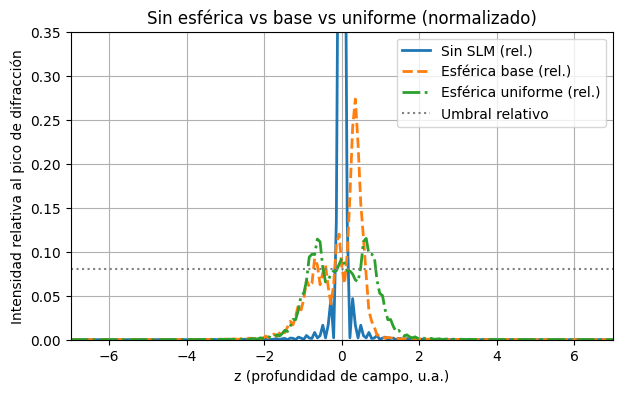

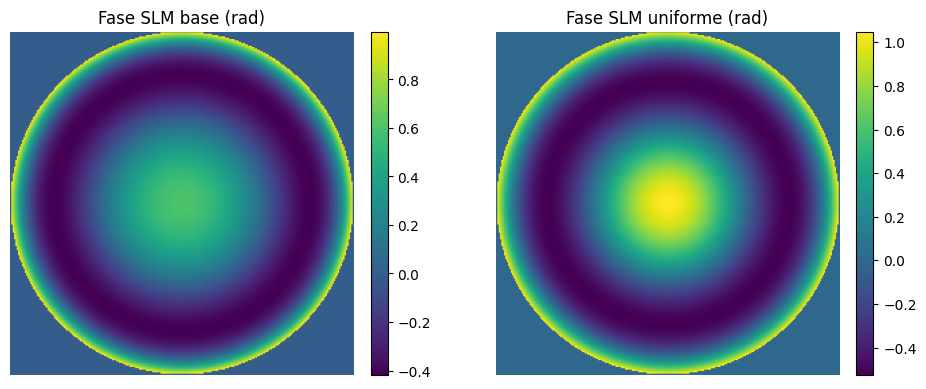

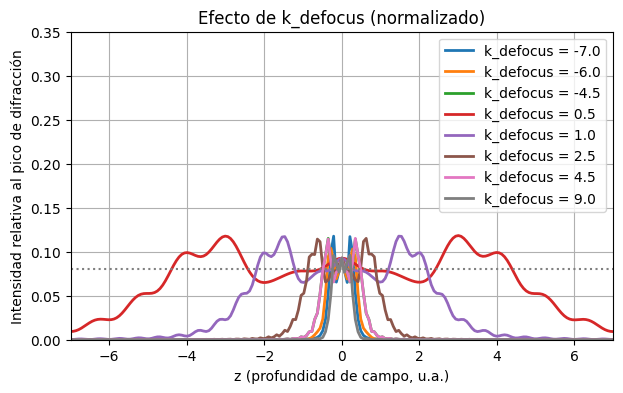

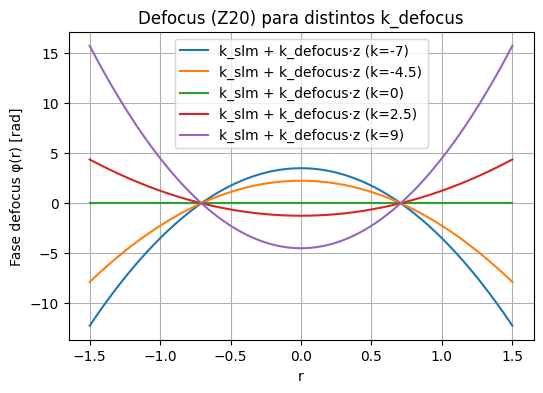

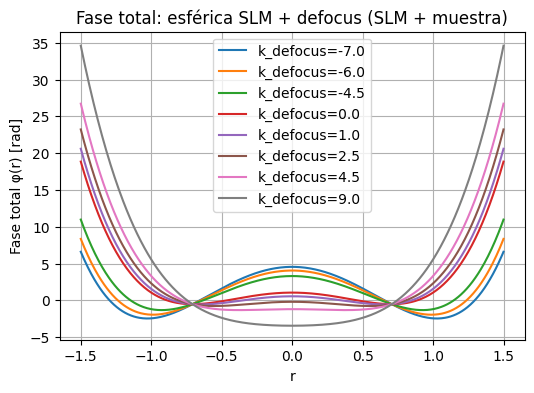


Áreas (plana vs Z40 vs Z60) sobre el umbral relativo:
  Plana: 4.467e+08 | Z40: 3.996e+08 | Z60: 3.890e+08


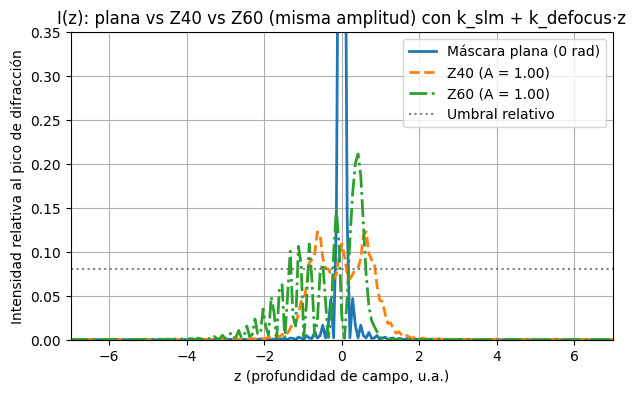

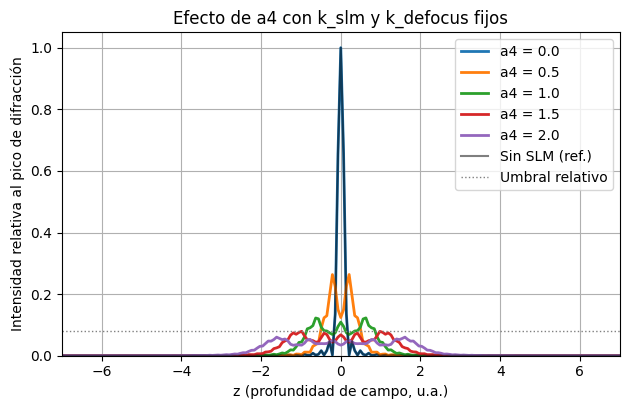

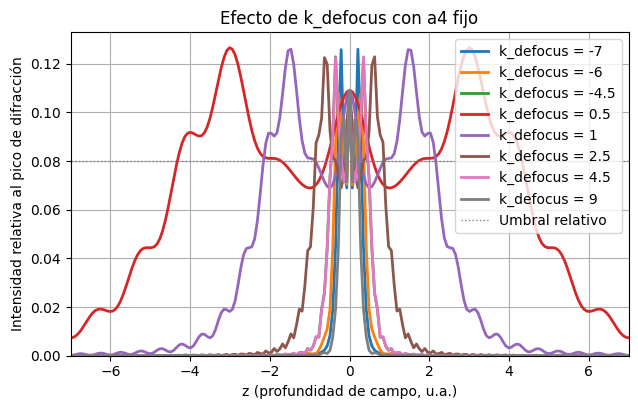

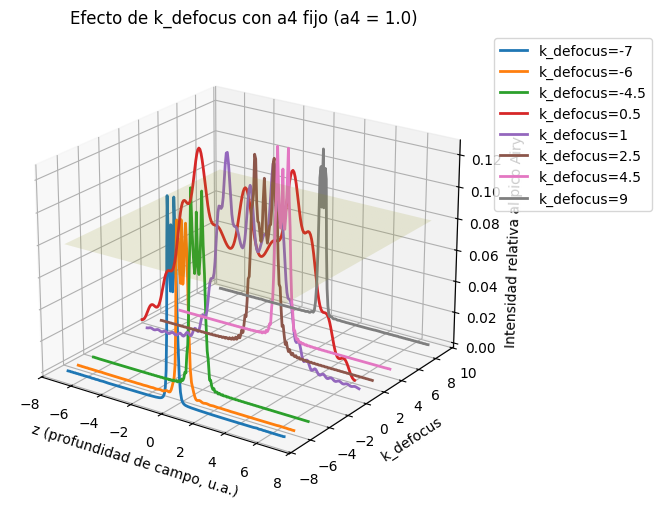

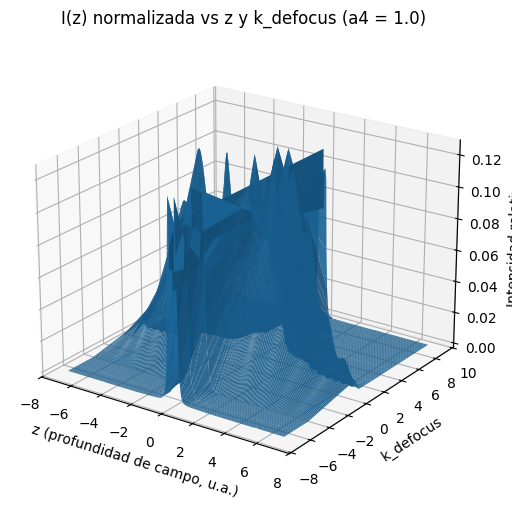

In [ ]:
# ============================================
#  Proyecto: EDOF con SLM y Zernike (script maestro)
#  Fase total: a4 Z40 + a6 Z60 + k_slm Z20 + k_muestra*z Z20
#  (compat: k_defocus_local ≡ k_muestra)
# ============================================

import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import minimize
from mpl_toolkits.mplot3d import Axes3D  # activa proyección 3D

# ============================================
# 0) PARÁMETROS AJUSTABLES
# ============================================
# Geometría / muestreo
N_opt   = 96
N_full  = 256
R_pupila = 1.0
z_full  = np.linspace(-7.0, 7.0, 201)   # eje z para gráficas principales
z_opt   = np.linspace(-2.0, 2.0, 41)    # eje z para optimización (más corto)

# Defocus (valores por defecto, cámbialos libremente)
k_slm_default     = 0.0   # defocus fijo (SLM)
k_muestra_default = 2.5   # defocus dependiente de z (muestra)

# Esférica "base" (no uniforme) para comparar
a4_base, a6_base = 0.8, 0.2

# Umbral para integrar áreas (relativo al pico Airy del caso sin SLM/SLM plano)
umbral_relativo = 0.08   # p.ej. 8%

# Para barridos de k_defocus (muestra)
k_muestra_vals =  [-7.0, -6.0, -4.5, 0.5, 1.0, 2.5, 4.5, 9.0]

# Para el inciso de máscaras plana vs Z40 vs Z60 (misma amplitud)
A_masc = 1.0

# ============================================
# 1) ZERNIKE (n, m) con m=0
# ============================================
def Z20(r):  # Defocus (n=2, m=0)
    return 2*r**2 - 1

def Z40(r):  # Esférica primaria (n=4, m=0)
    return 6*r**4 - 6*r**2 + 1

def Z60(r):  # Esférica de orden superior (n=6, m=0)
    return 20*r**6 - 30*r**4 + 12*r**2 - 1

# ============================================
# 2) Pupila y utilidades
# ============================================
def prepara_pupila(N, R=1.0):
    x = np.linspace(-R, R, N)
    y = np.linspace(-R, R, N)
    X, Y = np.meshgrid(x, y)
    Rm   = np.sqrt(X**2 + Y**2)
    apertura = (Rm <= 1.0).astype(float)
    return Rm, apertura

R_opt,  apertura_opt  = prepara_pupila(N_opt,  R_pupila)
R_full, apertura_full = prepara_pupila(N_full, R_pupila)

# ============================================
# 3) Fase total y perfil axial I(z)
#     phi = a4 Z40 + a6 Z60 + k_slm Z20 + k_muestra*z Z20
#     (compat: k_defocus_local ≡ k_muestra)
# ============================================
def phi_total(R, z, a4, a6, k_slm, k_muestra):
    return a4*Z40(R) + a6*Z60(R) + (k_slm + k_muestra*z)*Z20(R)

def perfil_axial(R, apertura, z_array, a4_slm, a6_slm,
                 k_slm=k_slm_default, k_muestra=k_muestra_default,
                 k_defocus_local=None, a2_static=0.0, z_shift=0.0):
    """
    k_muestra: coeficiente del término que multiplica a z (defocus de la 'muestra').
    k_slm    : defocus fijo del SLM (independiente de z).
    k_defocus_local: alias compatible de k_muestra (si se pasa, sobrescribe k_muestra).
    a2_static y z_shift quedan por compatibilidad (no alteran la ecuación principal).
    """
    if k_defocus_local is not None:
        k_muestra = k_defocus_local  # alias

    I_z = []
    for z in z_array:
        phi = phi_total(R, z, a4_slm, a6_slm, k_slm, k_muestra)
        pupil = apertura * np.exp(1j * 2*np.pi * phi)
        campo = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(pupil)))
        I    = np.abs(campo)**2
        cy, cx = I.shape[0]//2, I.shape[1]//2
        I_z.append(I[cy, cx])
    return np.array(I_z)

# ============================================
# 4) Coste para "esférica uniforme" (top-hat en ventana z)
#    (se usa el mismo k_slm/k_muestra durante la optimización)
# ============================================
def coste_uniforme(params, k_slm=k_slm_default, k_muestra=k_muestra_default):
    a4_slm, a6_slm = params
    I = perfil_axial(R_opt, apertura_opt, z_opt, a4_slm, a6_slm, k_slm, k_muestra)
    z_min, z_max = -0.5, 0.5
    idx = (z_opt >= z_min) & (z_opt <= z_max)
    I_roi = I[idx]
    if I_roi.mean() == 0:
        return 1e9
    I_norm = I_roi / I_roi.mean()
    return np.mean((I_norm - 1.0)**2)

# ============================================
# 5) Perfiles base / optimización / sin SLM (fase plana)
# ============================================
# Sin SLM (fase SLM=0) con defocus de muestra por defecto
I_sin_slm = perfil_axial(R_full, apertura_full, z_full, 0.0, 0.0,
                         k_slm=0.0, k_muestra=k_muestra_default)

# Esférica base (no uniforme)
I_base = perfil_axial(R_full, apertura_full, z_full, a4_base, a6_base,
                      k_slm=k_slm_default, k_muestra=k_muestra_default)

# Optimización (a4,a6) para uniforme
res = minimize(lambda p: coste_uniforme(p, k_slm_default, k_muestra_default),
               x0=np.array([a4_base, a6_base]),
               method='Nelder-Mead', options={'maxiter': 80, 'disp': False})
a4_uni, a6_uni = res.x

# Esférica uniforme (SLM óptimo)
I_unif = perfil_axial(R_full, apertura_full, z_full, a4_uni, a6_uni,
                      k_slm=k_slm_default, k_muestra=k_muestra_default)

print(f"[Optimización] a4_uni = {a4_uni:.4f}, a6_uni = {a6_uni:.4f}")

# ============================================
# 6) Normalización FÍSICA y área bajo la curva
# ============================================
I_airy_peak = I_sin_slm.max()
def rel(I): return I / I_airy_peak

thr_abs = umbral_relativo * I_airy_peak

def area_con_umbral(z, I, thr):
    mask = (I >= thr)
    if np.count_nonzero(mask) < 2:
        return 0.0
    i0, i1 = np.where(mask)[0][[0, -1]]
    return np.trapz(I[i0:i1+1], z[i0:i1+1])

A_sin  = area_con_umbral(z_full, I_sin_slm, thr_abs)
A_base = area_con_umbral(z_full, I_base,    thr_abs)
A_unif = area_con_umbral(z_full, I_unif,    thr_abs)

print("\nÁreas por encima del umbral (u. relativas z·intensidad):")
print(f"  Sin SLM      : {A_sin:.3e}")
print(f"  Esférica base: {A_base:.3e}")
print(f"  Esférica unif: {A_unif:.3e}")

ymin_rel, ymax_rel = 0.0, 0.35

# ============================================
# 7) GRÁFICAS comparativas (normalizadas)
# ============================================
plt.figure(figsize=(7,4))
plt.plot(z_full, rel(I_sin_slm),  '-',  lw=2, label='Sin SLM (rel.)')
plt.plot(z_full, rel(I_base),     '--', lw=2, label='Esférica base (rel.)')
plt.plot(z_full, rel(I_unif),     '-.', lw=2, label='Esférica uniforme (rel.)')
plt.axhline(umbral_relativo, color='gray', ls=':', label='Umbral relativo')
plt.xlabel('z (profundidad de campo, u.a.)')
plt.ylabel('Intensidad relativa al pico de difracción')
plt.title('Sin esférica vs base vs uniforme (normalizado)')
plt.grid(True); plt.legend()
plt.ylim(ymin_rel, ymax_rel); plt.xlim(z_full.min(), z_full.max())
plt.show()

# ============================================
# 8) Mapa de fase del SLM (base vs uniforme)
# ============================================
def fase_slm(R, a4, a6): return a4*Z40(R) + a6*Z60(R)

phi_base = fase_slm(R_full, a4_base, a6_base)*apertura_full
phi_unif = fase_slm(R_full, a4_uni,  a6_uni )*apertura_full

fig, axs = plt.subplots(1,2, figsize=(10,4))
im0 = axs[0].imshow(phi_base, origin='lower', cmap='viridis'); axs[0].axis('off')
axs[0].set_title('Fase SLM base (rad)');  plt.colorbar(im0, ax=axs[0], fraction=0.046, pad=0.04)
im1 = axs[1].imshow(phi_unif, origin='lower', cmap='viridis'); axs[1].axis('off')
axs[1].set_title('Fase SLM uniforme (rad)'); plt.colorbar(im1, ax=axs[1], fraction=0.046, pad=0.04)
plt.tight_layout(); plt.show()

# ============================================
# 9) Efecto de k_defocus (muestra) con esférica uniforme
# ============================================
plt.figure(figsize=(7,4))
for k_loc in k_muestra_vals:
    I_k = perfil_axial(R_full, apertura_full, z_full, a4_uni, a6_uni,
                       k_slm=k_slm_default, k_muestra=k_loc)
    plt.plot(z_full, rel(I_k), lw=2, label=f'k_defocus = {k_loc:.1f}')
plt.axhline(umbral_relativo, color='gray', ls=':')
plt.xlabel('z (profundidad de campo, u.a.)')
plt.ylabel('Intensidad relativa al pico de difracción')
plt.title('Efecto de k_defocus (normalizado)')
plt.grid(True); plt.legend()
plt.ylim(ymin_rel, ymax_rel); plt.xlim(z_full.min(), z_full.max())
plt.show()

# ============================================
# 10) Cortes 1D en pupila: defocus y total (ilustrativos)
# ============================================
r_1d = np.linspace(-1.5, 1.5, 600)
Z20_1d, Z40_1d, Z60_1d = Z20(r_1d), Z40(r_1d), Z60(r_1d)
z0 = 0.5
plt.figure(figsize=(6,4))
for k in [-7, -4.5, 0, 2.5, 9]:
    plt.plot(r_1d, (k_slm_default + k*z0)*Z20_1d, label=f'k_slm + k_defocus·z (k={k})')
plt.xlabel('r'); plt.ylabel('Fase defocus φ(r) [rad]')
plt.title('Defocus (Z20) para distintos k_defocus'); plt.grid(True); plt.legend(); plt.show()

phi_slm_uni_1d = a4_uni*Z40_1d + a6_uni*Z60_1d
plt.figure(figsize=(6,4))
for k in  [-7.0, -6.0, -4.5, 0.0, 1.0, 2.5, 4.5, 9.0]:
    plt.plot(r_1d, phi_slm_uni_1d + (k_slm_default + k*z0)*Z20_1d, label=f'k_defocus={k}')
plt.xlabel('r'); plt.ylabel('Fase total φ(r) [rad]')
plt.title('Fase total: esférica SLM + defocus (SLM + muestra)'); plt.grid(True); plt.legend(); plt.show()

# ============================================
# 11) Inciso: máscaras plana vs Z40 vs Z60 (misma amplitud)
# ============================================
def perfil_axial_con_mascara(R, apertura, z_array, phi_mask, k_slm, k_muestra):
    I_z = []
    for z in z_array:
        phi = phi_mask + (k_slm + k_muestra*z) * Z20(R)
        pupil = apertura * np.exp(1j * 2*np.pi * phi)
        campo = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(pupil)))
        I    = np.abs(campo)**2
        cy, cx = I.shape[0]//2, I.shape[1]//2
        I_z.append(I[cy, cx])
    return np.array(I_z)

phi_plana = np.zeros_like(R_full)
phi_Z40   = A_masc * Z40(R_full) * apertura_full
phi_Z60   = A_masc * Z60(R_full) * apertura_full

I_plana = perfil_axial_con_mascara(R_full, apertura_full, z_full, phi_plana,
                                   k_slm_default, k_muestra_default)
I_Z40   = perfil_axial_con_mascara(R_full, apertura_full, z_full, phi_Z40,
                                   k_slm_default, k_muestra_default)
I_Z60   = perfil_axial_con_mascara(R_full, apertura_full, z_full, phi_Z60,
                                   k_slm_default, k_muestra_default)

A_plana = area_con_umbral(z_full, I_plana, umbral_relativo*I_airy_peak)
A_Z40   = area_con_umbral(z_full, I_Z40,   umbral_relativo*I_airy_peak)
A_Z60   = area_con_umbral(z_full, I_Z60,   umbral_relativo*I_airy_peak)

print("\nÁreas (plana vs Z40 vs Z60) sobre el umbral relativo:")
print(f"  Plana: {A_plana:.3e} | Z40: {A_Z40:.3e} | Z60: {A_Z60:.3e}")

plt.figure(figsize=(7,4))
plt.plot(z_full, rel(I_plana), '-',  lw=2, label='Máscara plana (0 rad)')
plt.plot(z_full, rel(I_Z40),   '--', lw=2, label=f'Z40 (A = {A_masc:.2f})')
plt.plot(z_full, rel(I_Z60),   '-.', lw=2, label=f'Z60 (A = {A_masc:.2f})')
plt.axhline(umbral_relativo, color='gray', ls=':', label='Umbral relativo')
plt.xlabel('z (profundidad de campo, u.a.)')
plt.ylabel('Intensidad relativa al pico de difracción')
plt.title('I(z): plana vs Z40 vs Z60 (misma amplitud) con k_slm + k_defocus·z')
plt.grid(True); plt.legend()
plt.ylim(ymin_rel, ymax_rel); plt.xlim(z_full.min(), z_full.max())
plt.show()

# ============================================
# 12) Barridos prácticos
# ============================================

# (a) Barrido de a4 con k_slm y k_defocus fijos
a4_vals = [0.0, 0.5, 1.0, 1.5, 2.0]
plt.figure(figsize=(7.2, 4.2))
for a4 in a4_vals:
    I_a4 = perfil_axial(R_full, apertura_full, z_full, a4, a6_slm=0.0,
                        k_slm=k_slm_default, k_muestra=k_muestra_default)
    plt.plot(z_full, rel(I_a4), lw=2, label=f'a4 = {a4:.1f}')
plt.plot(z_full, rel(I_sin_slm), color='k', lw=1.5, alpha=0.5, label='Sin SLM (ref.)')
plt.axhline(umbral_relativo, color='gray', ls=':', lw=1, label='Umbral relativo')
plt.xlabel('z (profundidad de campo, u.a.)')
plt.ylabel('Intensidad relativa al pico de difracción')
plt.title('Efecto de a4 con k_slm y k_defocus fijos')
plt.grid(True); plt.legend(); plt.xlim(z_full.min(), z_full.max())
plt.ylim(0, max(0.35, plt.gca().get_ylim()[1])); plt.show()

# (b) Barrido de k_defocus con a4 fijo
def I_z_barrido_k(R, A, z_array, a4_fixed, k_slm, k_muestra):
    Iz = []
    phi_slm = a4_fixed * Z40(R)  # esférica fija
    for z in z_array:
        phi = phi_slm + (k_slm + k_muestra*z)*Z20(R)
        pupil = A * np.exp(1j * 2*np.pi * phi)
        field = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(pupil)))
        inten = np.abs(field)**2
        cy, cx = inten.shape[0]//2, inten.shape[1]//2
        Iz.append(inten[cy, cx])
    return np.array(Iz)

I_ref0 = perfil_axial(R_full, apertura_full, z_full, 0.0, 0.0, k_slm=0.0, k_muestra=0.0)
I_ref_peak = I_ref0.max()

plt.figure(figsize=(7.2, 4.2))
for km in [-7.0, -6.0, -4.5, 0.5, 1.0, 2.5, 4.5, 9.0]:
    I_k = I_z_barrido_k(R_full, apertura_full, z_full,
                        a4_fixed=1.0, k_slm=k_slm_default, k_muestra=km)
    plt.plot(z_full, I_k / I_ref_peak, lw=2, label=f'k_defocus = {km:g}')
plt.axhline(umbral_relativo, color='gray', ls=':', lw=1, label='Umbral relativo')
plt.xlabel('z (profundidad de campo, u.a.)'); plt.ylabel('Intensidad relativa al pico de difracción')
plt.title('Efecto de k_defocus con a4 fijo'); plt.grid(True); plt.legend()
plt.xlim(z_full.min(), z_full.max()); plt.ylim(0, None); plt.show()

# ============================================
# 3D: I(z) vs z vs k_defocus con a4 fijo (Z40)
#  - Etiquetas y leyenda en términos de k_defocus
#  - Excluye k_defocus = 0 para evitar la "línea" vertical
# ============================================
a4_fijo = 1.0       # esférica impuesta por el SLM (ajústalo si quieres)
a6_fijo = 0.0       # Z60 apagado para este inciso
k_list  =  [-7.0, -6.0, -4.5, 0.5, 1.0, 2.5, 4.5, 9.0]  # SIN el 0, como pediste

# Referencia: pico Airy sin SLM ni defocus
I_ref = []
for z in z_full:
    phi = 0.0 * Z40(R_full) + 0.0 * Z60(R_full) + 0.0 * z * Z20(R_full)
    pupil = apertura_full * np.exp(1j * 2*np.pi * phi)
    field = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(pupil)))
    inten = np.abs(field)**2
    cy, cx = inten.shape[0]//2, inten.shape[1]//2
    I_ref.append(inten[cy, cx])
I_ref = np.array(I_ref)
I_Airy_max = I_ref.max()

# Matriz I(k,z)
I_mat = []
for k in k_list:
    I_k = perfil_axial(R_full, apertura_full, z_full,
                       a4_slm=a4_fijo, a6_slm=a6_fijo,
                       k_defocus_local=k)   # alias ≡ k_muestra
    I_mat.append(I_k / I_Airy_max)
I_mat = np.array(I_mat)

# Cintas ("ribbons") 3D
fig = plt.figure(figsize=(8.2, 5.2))
ax = fig.add_subplot(111, projection='3d')
for i, k in enumerate(k_list):
    ax.plot(z_full, np.full_like(z_full, k), I_mat[i], lw=2, label=f'k_defocus={k:g}')
thr = umbral_relativo
Zg, Kg = np.meshgrid(z_full, np.linspace(min(k_list), max(k_list), 2))
Ig = np.full_like(Zg, thr)
ax.plot_surface(Zg, Kg, Ig, alpha=0.15)
ax.set_xlabel('z (profundidad de campo, u.a.)')
ax.set_ylabel('k_defocus')
ax.set_zlabel('Intensidad relativa al pico Airy')
ax.set_title(f'Efecto de k_defocus con a4 fijo (a4 = {a4_fijo})')
ax.view_init(elev=22, azim=-55)
plt.legend(loc='upper left', bbox_to_anchor=(1.02, 1.0))
plt.tight_layout(); plt.show()

# Superficie 3D continua (opcional)
K_mesh, Z_mesh = np.meshgrid(k_list, z_full, indexing='ij')
fig = plt.figure(figsize=(8.2, 5.2))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(Z_mesh, K_mesh, I_mat, rstride=1, cstride=1, linewidth=0,
                       antialiased=True, alpha=0.9)
ax.set_xlabel('z (profundidad de campo, u.a.)')
ax.set_ylabel('k_defocus')
ax.set_zlabel('Intensidad relativa')
ax.set_title(f'I(z) normalizada vs z y k_defocus (a4 = {a4_fijo})')
ax.view_init(elev=22, azim=-55)
plt.tight_layout(); plt.show()


/tmp/ipython-input-2582875845.py:125: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  a4_uni = float(res.x)


[Optimización] a4_uni = 0.7102

Áreas sobre el umbral (u. relativas z·intensidad):
  Sin SLM      : 4.629e+08
  Esférica base: 4.120e+08
  Esférica unif: 4.297e+08


/tmp/ipython-input-2582875845.py:145: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(I[i0:i1+1], z[i0:i1+1])


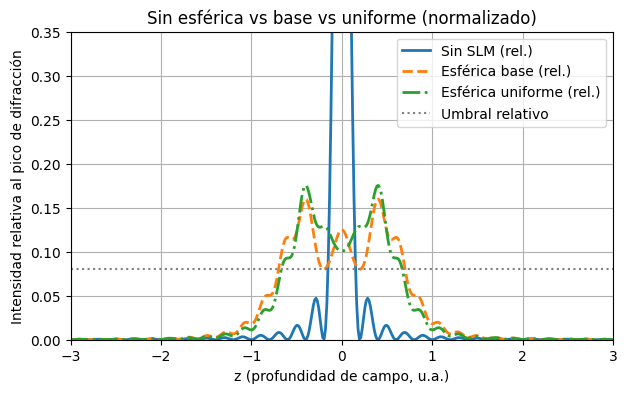

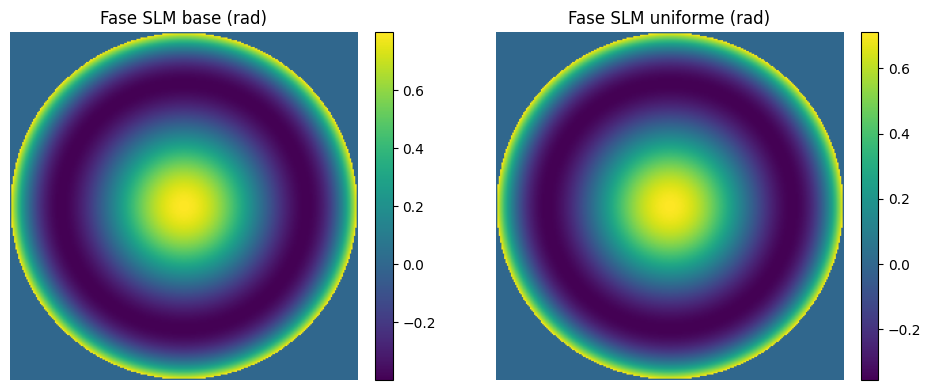

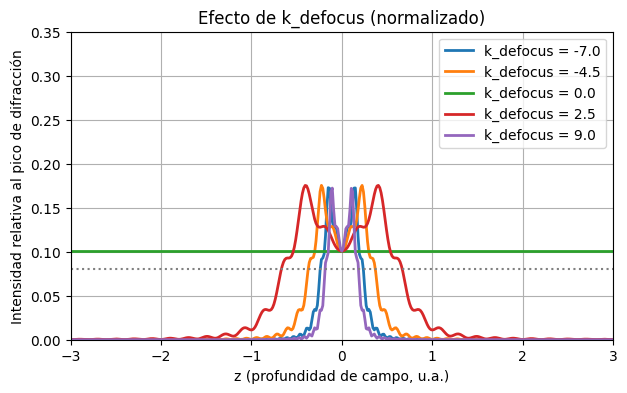

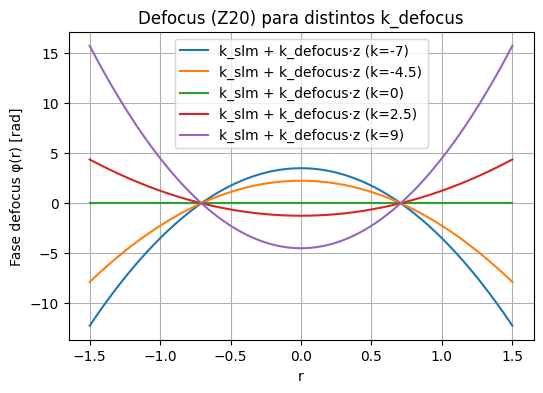

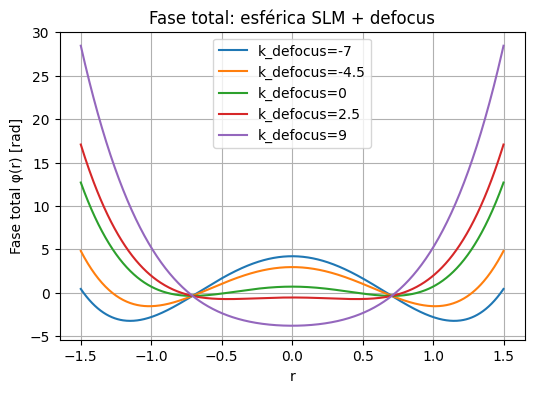


Áreas (plana vs Z40) sobre el umbral relativo:
  Plana: 4.629e+08 | Z40: 4.067e+08


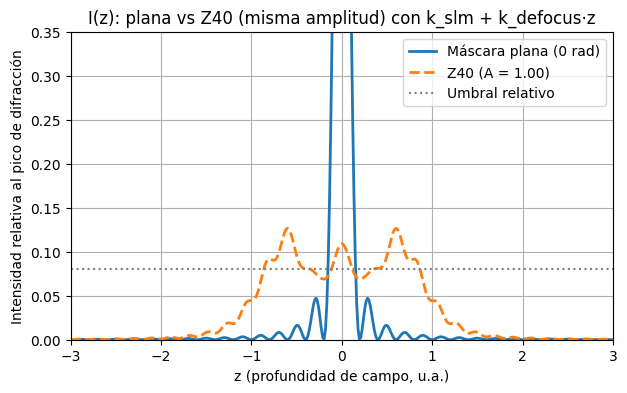

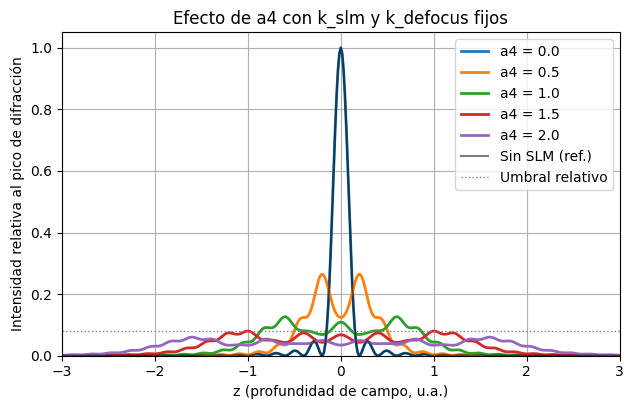

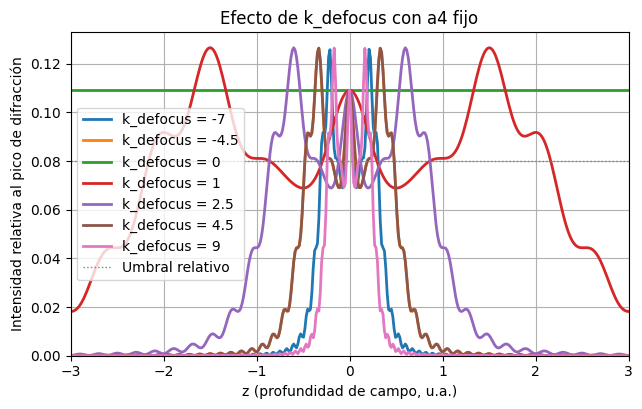

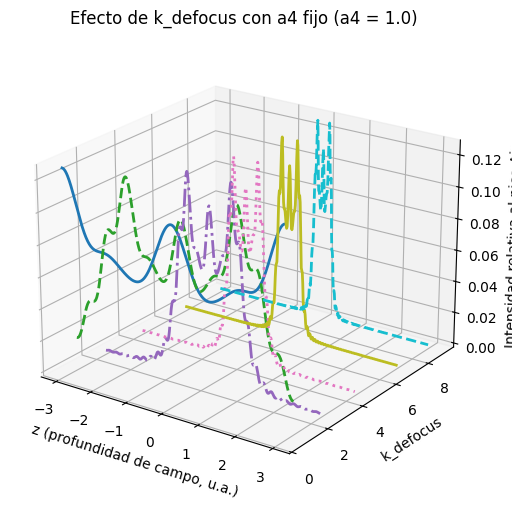

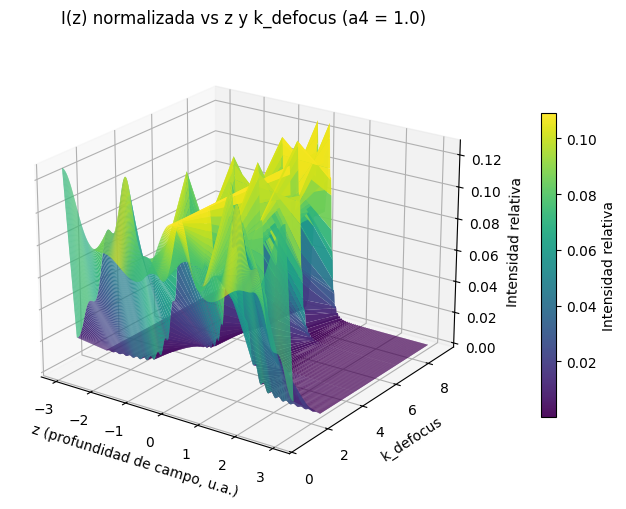

In [ ]:
# ============================================
#  Proyecto: EDOF con SLM y Zernike (script maestro)
#  Fase total: phi = a4 Z40 + k_slm Z20 + k_defocus*z Z20
#  Nota: k_defocus_local es alias de k_defocus (muestra)
# ============================================

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from mpl_toolkits.mplot3d import Axes3D  # activa proyección 3D

# ============================================
# 0) PARÁMETROS AJUSTABLES
# ============================================
# Geometría / muestreo
N_opt    = 96
N_full   = 256
R_pupila = 1.0
z_full   = np.linspace(-3.0, 3.0, 401)   # más denso para ver mejor los picos
z_opt    = np.linspace(-2.0, 2.0, 41)    # eje z para optimización

# Defocus (cámbialos libremente)
k_slm_default   = 0.0   # defocus fijo del SLM (independiente de z)
k_defocus_default = 2.5 # defocus dependiente de z (la "muestra")

# Esférica base para comparar
a4_base = 0.8

# Umbral relativo (vs pico Airy sin SLM) para métricas/DOF
umbral_relativo = 0.08

# Barridos de k_defocus (intermedios y sin 0 en 3D para evitar “línea”)
# Barridos de k_defocus
k_defocus_vals_2D = [-7.0, -4.5, 0.0, 2.5, 9.0]  # si quieres, esto lo puedes dejar igual

# Para la gráfica 3D: solo k_defocus positivos y pocos valores para no saturar
k_defocus_vals_3D = [0.5, 1.0, 2.5, 4.5, 7.0, 9.0]


# Amplitud para comparación de máscaras
A_masc = 1.0

# ============================================
# 1) ZERNIKE (m=0) necesarios
# ============================================
def Z20(r):  # Defocus (n=2, m=0)
    return 2*r**2 - 1

def Z40(r):  # Esférica primaria (n=4, m=0)
    return 6*r**4 - 6*r**2 + 1

# ============================================
# 2) Pupila circular y utilidades
# ============================================
def prepara_pupila(N, R=1.0):
    x = np.linspace(-R, R, N)
    y = np.linspace(-R, R, N)
    X, Y = np.meshgrid(x, y)
    Rm   = np.sqrt(X**2 + Y**2)
    apertura = (Rm <= 1.0).astype(float)
    return Rm, apertura

R_opt,  apertura_opt  = prepara_pupila(N_opt,  R_pupila)
R_full, apertura_full = prepara_pupila(N_full, R_pupila)

# ============================================
# 3) Fase total y perfil axial I(z)
#     phi = a4 Z40 + k_slm Z20 + k_defocus*z Z20
# ============================================
def phi_total(R, z, a4, k_slm, k_defocus):
    return a4*Z40(R) + (k_slm + k_defocus*z)*Z20(R)

def perfil_axial(R, apertura, z_array, a4_slm,
                 k_slm=k_slm_default, k_defocus=k_defocus_default,
                 k_defocus_local=None, a2_static=0.0, z_shift=0.0):
    """
    k_defocus: coeficiente del término que multiplica a z (defocus 'muestra').
    k_slm    : defocus fijo aplicado por el SLM (independiente de z).
    k_defocus_local: alias compatible; si se pasa, sobrescribe k_defocus.
    a2_static y z_shift quedan por compatibilidad (no afectan la ecuación principal).
    """
    if k_defocus_local is not None:
        k_defocus = k_defocus_local

    I_z = []
    for z in z_array:
        phi = phi_total(R, z, a4_slm, k_slm, k_defocus)
        pupil = apertura * np.exp(1j * 2*np.pi * phi)
        campo = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(pupil)))
        I    = np.abs(campo)**2
        cy, cx = I.shape[0]//2, I.shape[1]//2
        I_z.append(I[cy, cx])
    return np.array(I_z)

# ============================================
# 4) Coste para "esférica uniforme" (top-hat en ventana z)
#    -> solo optimizamos a4
# ============================================
def coste_uniforme(a4, k_slm=k_slm_default, k_defocus=k_defocus_default):
    I = perfil_axial(R_opt, apertura_opt, z_opt, a4_slm=a4,
                     k_slm=k_slm, k_defocus=k_defocus)
    z_min, z_max = -0.5, 0.5
    idx  = (z_opt >= z_min) & (z_opt <= z_max)
    I_roi = I[idx]
    if I_roi.mean() == 0:
        return 1e9
    I_norm = I_roi / I_roi.mean()
    return np.mean((I_norm - 1.0)**2)

# ============================================
# 5) Perfiles base / optimización / sin SLM
# ============================================
# Sin SLM (fase plana) con defocus de muestra por defecto
I_sin_slm = perfil_axial(R_full, apertura_full, z_full, a4_slm=0.0,
                         k_slm=0.0, k_defocus=k_defocus_default)

# Esférica base
I_base = perfil_axial(R_full, apertura_full, z_full, a4_slm=a4_base,
                      k_slm=k_slm_default, k_defocus=k_defocus_default)

# Optimización (a4) para top-hat axial
res = minimize(lambda a: coste_uniforme(a, k_slm_default, k_defocus_default),
               x0=np.array([a4_base]), method='Nelder-Mead',
               options={'maxiter': 80, 'disp': False})
a4_uni = float(res.x)

# Esférica uniforme (SLM óptimo)
I_unif = perfil_axial(R_full, apertura_full, z_full, a4_slm=a4_uni,
                      k_slm=k_slm_default, k_defocus=k_defocus_default)

print(f"[Optimización] a4_uni = {a4_uni:.4f}")

# ============================================
# 6) Normalización FÍSICA y área bajo la curva
# ============================================
I_airy_peak = I_sin_slm.max()
def rel(I): return I / I_airy_peak
thr_abs = umbral_relativo * I_airy_peak

def area_con_umbral(z, I, thr):
    mask = (I >= thr)
    if np.count_nonzero(mask) < 2:
        return 0.0
    i0, i1 = np.where(mask)[0][[0, -1]]
    return np.trapz(I[i0:i1+1], z[i0:i1+1])

A_sin  = area_con_umbral(z_full, I_sin_slm, thr_abs)
A_base = area_con_umbral(z_full, I_base,    thr_abs)
A_unif = area_con_umbral(z_full, I_unif,    thr_abs)
print("\nÁreas sobre el umbral (u. relativas z·intensidad):")
print(f"  Sin SLM      : {A_sin:.3e}")
print(f"  Esférica base: {A_base:.3e}")
print(f"  Esférica unif: {A_unif:.3e}")

ymin_rel, ymax_rel = 0.0, 0.35

# ============================================
# 7) GRÁFICAS comparativas (normalizadas)
# ============================================
plt.figure(figsize=(7,4))
plt.plot(z_full, rel(I_sin_slm),  '-',  lw=2, label='Sin SLM (rel.)')
plt.plot(z_full, rel(I_base),     '--', lw=2, label='Esférica base (rel.)')
plt.plot(z_full, rel(I_unif),     '-.', lw=2, label='Esférica uniforme (rel.)')
plt.axhline(umbral_relativo, color='gray', ls=':', label='Umbral relativo')
plt.xlabel('z (profundidad de campo, u.a.)')
plt.ylabel('Intensidad relativa al pico de difracción')
plt.title('Sin esférica vs base vs uniforme (normalizado)')
plt.grid(True); plt.legend()
plt.ylim(ymin_rel, ymax_rel); plt.xlim(z_full.min(), z_full.max())
plt.show()

# ============================================
# 8) Mapa de fase del SLM (base vs uniforme)
# ============================================
phi_base = a4_base*Z40(R_full) * apertura_full
phi_unif = a4_uni *Z40(R_full) * apertura_full
fig, axs = plt.subplots(1,2, figsize=(10,4))
im0 = axs[0].imshow(phi_base, origin='lower', cmap='viridis'); axs[0].axis('off')
axs[0].set_title('Fase SLM base (rad)');  plt.colorbar(im0, ax=axs[0], fraction=0.046, pad=0.04)
im1 = axs[1].imshow(phi_unif, origin='lower', cmap='viridis'); axs[1].axis('off')
axs[1].set_title('Fase SLM uniforme (rad)'); plt.colorbar(im1, ax=axs[1], fraction=0.046, pad=0.04)
plt.tight_layout(); plt.show()

# ============================================
# 9) Efecto de k_defocus (2D, normalizado) con esférica uniforme
# ============================================
plt.figure(figsize=(7,4))
for k_loc in k_defocus_vals_2D:
    I_k = perfil_axial(R_full, apertura_full, z_full, a4_slm=a4_uni,
                       k_slm=k_slm_default, k_defocus=k_loc)
    plt.plot(z_full, rel(I_k), lw=2, label=f'k_defocus = {k_loc:.1f}')
plt.axhline(umbral_relativo, color='gray', ls=':')
plt.xlabel('z (profundidad de campo, u.a.)')
plt.ylabel('Intensidad relativa al pico de difracción')
plt.title('Efecto de k_defocus (normalizado)')
plt.grid(True); plt.legend()
plt.ylim(ymin_rel, ymax_rel); plt.xlim(z_full.min(), z_full.max())
plt.show()

# ============================================
# 10) Cortes 1D en pupila: defocus y fase total (ilustrativos)
# ============================================
r_1d = np.linspace(-1.5, 1.5, 600)
Z20_1d, Z40_1d = Z20(r_1d), Z40(r_1d)
z0 = 0.5
plt.figure(figsize=(6,4))
for k in [-7, -4.5, 0, 2.5, 9]:
    plt.plot(r_1d, (k_slm_default + k*z0)*Z20_1d, label=f'k_slm + k_defocus·z (k={k})')
plt.xlabel('r'); plt.ylabel('Fase defocus φ(r) [rad]')
plt.title('Defocus (Z20) para distintos k_defocus'); plt.grid(True); plt.legend(); plt.show()

phi_slm_uni_1d = a4_uni*Z40_1d
plt.figure(figsize=(6,4))
for k in [-7, -4.5, 0, 2.5, 9]:
    plt.plot(r_1d, phi_slm_uni_1d + (k_slm_default + k*z0)*Z20_1d, label=f'k_defocus={k}')
plt.xlabel('r'); plt.ylabel('Fase total φ(r) [rad]')
plt.title('Fase total: esférica SLM + defocus'); plt.grid(True); plt.legend(); plt.show()

# ============================================
# 11) Inciso de máscaras: plana vs Z40 (misma amplitud)
# ============================================
def perfil_axial_con_mascara(R, apertura, z_array, phi_mask, k_slm, k_defocus):
    I_z = []
    for z in z_array:
        phi = phi_mask + (k_slm + k_defocus*z) * Z20(R)
        pupil = apertura * np.exp(1j * 2*np.pi * phi)
        campo = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(pupil)))
        I    = np.abs(campo)**2
        cy, cx = I.shape[0]//2, I.shape[1]//2
        I_z.append(I[cy, cx])
    return np.array(I_z)

phi_plana = np.zeros_like(R_full)
phi_Z40   = A_masc * Z40(R_full) * apertura_full

I_plana = perfil_axial_con_mascara(R_full, apertura_full, z_full, phi_plana,
                                   k_slm_default, k_defocus_default)
I_Z40   = perfil_axial_con_mascara(R_full, apertura_full, z_full, phi_Z40,
                                   k_slm_default, k_defocus_default)

A_plana = area_con_umbral(z_full, I_plana, umbral_relativo*I_airy_peak)
A_Z40   = area_con_umbral(z_full, I_Z40,   umbral_relativo*I_airy_peak)
print("\nÁreas (plana vs Z40) sobre el umbral relativo:")
print(f"  Plana: {A_plana:.3e} | Z40: {A_Z40:.3e}")

plt.figure(figsize=(7,4))
plt.plot(z_full, rel(I_plana), '-',  lw=2, label='Máscara plana (0 rad)')
plt.plot(z_full, rel(I_Z40),   '--', lw=2, label=f'Z40 (A = {A_masc:.2f})')
plt.axhline(umbral_relativo, color='gray', ls=':', label='Umbral relativo')
plt.xlabel('z (profundidad de campo, u.a.)')
plt.ylabel('Intensidad relativa al pico de difracción')
plt.title('I(z): plana vs Z40 (misma amplitud) con k_slm + k_defocus·z')
plt.grid(True); plt.legend()
plt.ylim(ymin_rel, ymax_rel); plt.xlim(z_full.min(), z_full.max())
plt.show()

# ============================================
# 12) Barridos prácticos
# ============================================

# (a) Barrido de a4 con k_slm y k_defocus fijos
a4_vals = [0.0, 0.5, 1.0, 1.5, 2.0]
plt.figure(figsize=(7.2, 4.2))
for a4 in a4_vals:
    I_a4 = perfil_axial(R_full, apertura_full, z_full, a4_slm=a4,
                        k_slm=k_slm_default, k_defocus=k_defocus_default)
    plt.plot(z_full, rel(I_a4), lw=2, label=f'a4 = {a4:.1f}')
plt.plot(z_full, rel(I_sin_slm), color='k', lw=1.5, alpha=0.5, label='Sin SLM (ref.)')
plt.axhline(umbral_relativo, color='gray', ls=':', lw=1, label='Umbral relativo')
plt.xlabel('z (profundidad de campo, u.a.)')
plt.ylabel('Intensidad relativa al pico de difracción')
plt.title('Efecto de a4 con k_slm y k_defocus fijos')
plt.grid(True); plt.legend(); plt.xlim(z_full.min(), z_full.max())
plt.ylim(0, max(0.35, plt.gca().get_ylim()[1])); plt.show()

# (b) Barrido de k_defocus con a4 fijo
def I_z_barrido_k(R, A, z_array, a4_fixed, k_slm, k_defocus):
    Iz = []
    phi_slm = a4_fixed * Z40(R)  # esférica fija
    for z in z_array:
        phi = phi_slm + (k_slm + k_defocus*z)*Z20(R)
        pupil = A * np.exp(1j * 2*np.pi * phi)
        field = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(pupil)))
        inten = np.abs(field)**2
        cy, cx = inten.shape[0]//2, inten.shape[1]//2
        Iz.append(inten[cy, cx])
    return np.array(Iz)

I_ref0 = perfil_axial(R_full, apertura_full, z_full, a4_slm=0.0,
                      k_slm=0.0, k_defocus=0.0)
I_ref_peak = I_ref0.max()

plt.figure(figsize=(7.2, 4.2))
for kd in [-7.0, -4.5, 0.0, 1.0, 2.5, 4.5, 9.0]:
    I_k = I_z_barrido_k(R_full, apertura_full, z_full,
                        a4_fixed=1.0, k_slm=k_slm_default, k_defocus=kd)
    plt.plot(z_full, I_k / I_ref_peak, lw=2, label=f'k_defocus = {kd:g}')
plt.axhline(umbral_relativo, color='gray', ls=':', lw=1, label='Umbral relativo')
plt.xlabel('z (profundidad de campo, u.a.)'); plt.ylabel('Intensidad relativa al pico de difracción')
plt.title('Efecto de k_defocus con a4 fijo'); plt.grid(True); plt.legend()
plt.xlim(z_full.min(), z_full.max()); plt.ylim(0, None); plt.show()

# ============================================
# 13) 3D: I(z) vs z vs k_defocus con a4 fijo (ribbons SIN plano ni DOF)
# ============================================
a4_fijo = 1.0

# Referencia: pico Airy sin SLM ni defocus
I_ref = []
for z in z_full:
    phi = 0.0
    pupil = apertura_full * np.exp(1j * 2*np.pi * phi)
    field = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(pupil)))
    inten = np.abs(field)**2
    cy, cx = inten.shape[0]//2, inten.shape[1]//2
    I_ref.append(inten[cy, cx])
I_ref = np.array(I_ref)
I_Airy_max = I_ref.max()

# Matriz I(k,z)
I_mat = []
for k in k_defocus_vals_3D:
    I_k = perfil_axial(R_full, apertura_full, z_full,
                       a4_slm=a4_fijo, k_slm=k_slm_default,
                       k_defocus=k)
    I_mat.append(I_k / I_Airy_max)
I_mat = np.array(I_mat)

# Colores y estilos diferentes para cada k_defocus
colors = plt.cm.tab10(np.linspace(0, 1, len(k_defocus_vals_3D)))
linestyles = ['-', '--', '-.', ':']

fig = plt.figure(figsize=(8.2, 5.6))
ax = fig.add_subplot(111, projection='3d')

for i, k in enumerate(k_defocus_vals_3D):
    ax.plot(
        z_full,
        np.full_like(z_full, k),
        I_mat[i],
        lw=2,
        color=colors[i],
        linestyle=linestyles[i % len(linestyles)]
        # sin "label" para que no haya leyenda de k_defocus
    )

ax.set_xlabel('z (profundidad de campo, u.a.)')
ax.set_ylabel('k_defocus')
ax.set_zlabel('Intensidad relativa al pico Airy')
ax.set_title(f'Efecto de k_defocus con a4 fijo (a4 = {a4_fijo})')
ax.view_init(elev=22, azim=-55)
plt.tight_layout()
plt.show()

# Superficie 3D continua con barra de color
K_mesh, Z_mesh = np.meshgrid(k_defocus_vals_3D, z_full, indexing='ij')
fig = plt.figure(figsize=(8.2, 5.2))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(Z_mesh, K_mesh, I_mat, rstride=1, cstride=1,
                       linewidth=0, antialiased=True, alpha=0.95, cmap='viridis')
cb = plt.colorbar(surf, ax=ax, shrink=0.65, pad=0.08)
cb.set_label('Intensidad relativa')
ax.set_xlabel('z (profundidad de campo, u.a.)')
ax.set_ylabel('k_defocus')
ax.set_zlabel('Intensidad relativa')
ax.set_title(f'I(z) normalizada vs z y k_defocus (a4 = {a4_fijo})')
ax.view_init(elev=22, azim=-55)
plt.tight_layout(); plt.show()


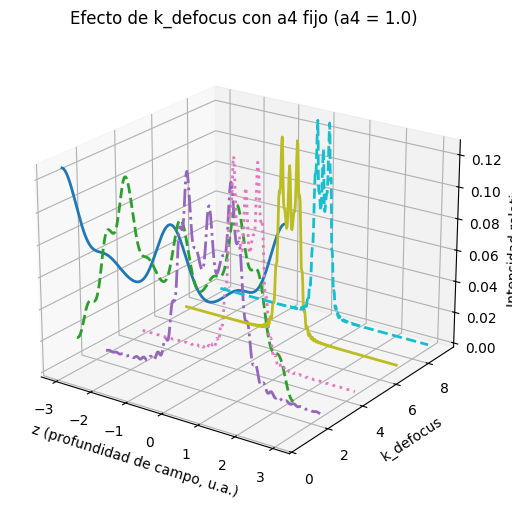

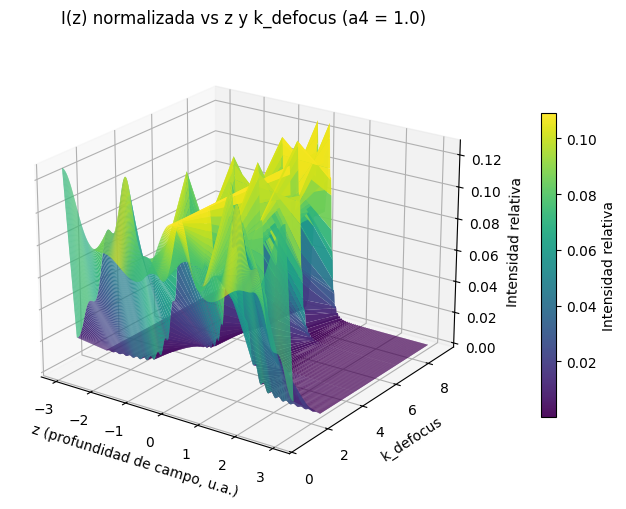

In [ ]:
# ============================================
# 13) 3D: I(z) vs z vs k_defocus con a4 fijo (ribbons SIN plano ni DOF)
# ============================================
a4_fijo = 1.0

# Referencia: pico Airy sin SLM ni defocus
I_ref = []
for z in z_full:
    phi = 0.0
    pupil = apertura_full * np.exp(1j * 2*np.pi * phi)
    field = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(pupil)))
    inten = np.abs(field)**2
    cy, cx = inten.shape[0]//2, inten.shape[1]//2
    I_ref.append(inten[cy, cx])
I_ref = np.array(I_ref)
I_Airy_max = I_ref.max()

# Matriz I(k,z)
I_mat = []
for k in k_defocus_vals_3D:
    I_k = perfil_axial(R_full, apertura_full, z_full,
                       a4_slm=a4_fijo, k_slm=k_slm_default,
                       k_defocus=k)
    I_mat.append(I_k / I_Airy_max)
I_mat = np.array(I_mat)

# Colores y estilos diferentes para cada k_defocus
colors = plt.cm.tab10(np.linspace(0, 1, len(k_defocus_vals_3D)))
linestyles = ['-', '--', '-.', ':']

fig = plt.figure(figsize=(8.2, 5.2))
ax = fig.add_subplot(111, projection='3d')

for i, k in enumerate(k_defocus_vals_3D):
    ax.plot(
        z_full,
        np.full_like(z_full, k),
        I_mat[i],
        lw=2,
        color=colors[i],
        linestyle=linestyles[i % len(linestyles)]
        # sin "label" para que no haya leyenda de k_defocus
    )

ax.set_xlabel('z (profundidad de campo, u.a.)')
ax.set_ylabel('k_defocus')
ax.set_zlabel('Intensidad relativa')
ax.set_title(f'Efecto de k_defocus con a4 fijo (a4 = {a4_fijo})')
ax.view_init(elev=22, azim=-55)
plt.tight_layout()
plt.show()

# Superficie 3D continua con barra de color
K_mesh, Z_mesh = np.meshgrid(k_defocus_vals_3D, z_full, indexing='ij')
fig = plt.figure(figsize=(8.2, 5.2))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(Z_mesh, K_mesh, I_mat, rstride=1, cstride=1,
                       linewidth=0, antialiased=True, alpha=0.95, cmap='viridis')
cb = plt.colorbar(surf, ax=ax, shrink=0.65, pad=0.08)
cb.set_label('Intensidad relativa')
ax.set_xlabel('z (profundidad de campo, u.a.)')
ax.set_ylabel('k_defocus')
ax.set_zlabel('Intensidad relativa')
ax.set_title(f'I(z) normalizada vs z y k_defocus (a4 = {a4_fijo})')
ax.view_init(elev=22, azim=-55)
plt.tight_layout(); plt.show()